In [ ]:
# Import những thư viện cần thiết
import re
import nltk
import string 
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn import metrics
from sklearn.model_selection import train_test_split
from string import punctuation
pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore', category=DeprecationWarning)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Read data
file_data = r'drive/My Drive/Colab Notebooks/data/fake_job_postings.csv'
df = pd.read_csv(file_data)

In [ ]:
# Xem dữ liệu đầu tiên (mặc định là 5 dòng đầu tiên)
df.head()

job_id  ... fraudulent
0       1  ...          0
1       2  ...          0
2       3  ...          0
3       4  ...          0
4       5  ...          0

[5 rows x 18 columns]

### Data Inspection

In [ ]:
# Xem 10 giá trị đầu tiên của biến target fraudulent = 1 (lừa đảo) 
df[df['fraudulent'] == 1].head(10)

job_id  ... fraudulent
98       99  ...          1
144     145  ...          1
173     174  ...          1
180     181  ...          1
215     216  ...          1
357     358  ...          1
493     494  ...          1
537     538  ...          1
573     574  ...          1
584     585  ...          1

[10 rows x 18 columns]

In [ ]:
# Xem 10 giá trị đầu tiên của biến target fraudulent = 0 (không lừa đảo) 
df[df['fraudulent'] == 0].head(10)

job_id  ... fraudulent
0       1  ...          0
1       2  ...          0
2       3  ...          0
3       4  ...          0
4       5  ...          0
5       6  ...          0
6       7  ...          0
7       8  ...          0
8       9  ...          0
9      10  ...          0

[10 rows x 18 columns]

In [ ]:
# Xem hình dạng của dataframe
df.shape

(17880, 18)

In [ ]:
# Thống kê có bao nhiêu bài Post là lừa đảo / không lừa đảo
df['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

### Data Cleaning

In [ ]:
# Kiểm tra giá trị NULL
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
# Drop đi những thuộc tính không sử dụng. Do đây là bài toán text classification
df.drop(['job_id', 'salary_range','telecommuting', 'has_company_logo','has_questions'], axis=1, inplace =True)

In [ ]:
df.head()

title  ... fraudulent
0                           Marketing Intern  ...          0
1  Customer Service - Cloud Video Production  ...          0
2    Commissioning Machinery Assistant (CMA)  ...          0
3          Account Executive - Washington DC  ...          0
4                        Bill Review Manager  ...          0

[5 rows x 13 columns]

In [ ]:
# Thay thế giá trị NaN thành ' '
df.fillna(' ', inplace=True)

In [ ]:
# Kiểm tra lại giá trị NULL
df.isnull().sum()

title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [ ]:
# Thực hiện nối giá trị các thuộc tính lại với nhau và lưu trữ tại thuộc tính 'text'
df['text'] = df['title'] + ' '+ df['location']+' ' + df['department']+ ' '+df['company_profile']+ ' '+df['description']+ ' '+\
df['requirements']+ ' '+df['benefits']+' '+df['employment_type']+' '+df['required_experience']+' '+\
df['required_education']+' '+df['industry']+' '+df['function']

In [ ]:
# Drop đi những thuộc tính vừa mới nối lại bên trên
df.drop(['title', 'location', 'department', 'company_profile', 'description', 'required_experience','requirements', 'benefits', 'employment_type','required_education',\
         'industry','function'], inplace=True, axis=1)

In [ ]:
# Review lại DF
df.text[1]

"Customer Service - Cloud Video Production NZ, , Auckland Success 90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 Seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish. http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 Seconds provides a 100% success guarantee.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest in

In [ ]:
# Hàm dùng để xóa các pattern và thay thế bằng ''
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(re.escape(i), '', input_txt)
    return input_txt

In [ ]:
# Loại bỏ những đường link
df['tidy_text'] = np.vectorize(remove_pattern)(df['text'], 'http\S+')

In [ ]:
df.tidy_text[5]

'Accounting Clerk US, MD,      Job OverviewApex is an environmental consulting firm that offers stable leadership and growth and views employees as valuable resources. We are seeking a self-motivated, multi-faceted Accounts Payable Clerk to join our team in Rockville, MD and become an integral part of our continued success story. This position entails processing high volume of invoices and working in a fast pace environment; keying and verifying various types of invoices to General Ledger accounts and job numbers submitted by vendors and company personnel; and calculating balance due to vendor by reviewing history of prior payments made to an account. Candidate must be able to answer vendor and personnel inquiries via phone or email. QualificationsThis position requires a high school diploma and 2-5 years of relevant work experience; keen attention to detail; knowledge of commonly-used concepts, practices, and procedures within the accounting field; experience with accounting software;

In [ ]:
# Loại bỏ \xa0
df['tidy_text'] = np.vectorize(remove_pattern)(df['tidy_text'], '\xa0')

In [ ]:
df['tidy_text'] = np.vectorize(remove_pattern)(df['tidy_text'], '#\S+')

In [ ]:
df.tidy_text.head(2)

0    Marketing Intern New York Marketing Food and created groundbreaking and award winning cooking site support connect and celebrate home cooks and give them everything they need one place have top ed...
1    Customer Service Cloud Video Production Auckland Success Seconds the worlds Cloud Video Production Service Seconds the worlds Cloud Video Production Service enabling brands and agencies get high q...
Name: tidy_text, dtype: object

In [ ]:
# Loại bỏ tất cả các kí tự dư thừa ngoài trừ bảng chữ cái thường và hoa
df.tidy_text = df.tidy_text.str.replace("[^a-zA-Z]", ' ')

In [ ]:
# Loại bỏ những khoảng trống thừa
df['tidy_text'] = df['tidy_text'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
# Loại bỏ những từ có ít hơn 3 ký tự
df['tidy_text'] = df['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [ ]:
df.head()

fraudulent  ...                                                                                                                                                                                                tidy_text
0           0  ...  Marketing Intern New York Marketing Food and created groundbreaking and award winning cooking site support connect and celebrate home cooks and give them everything they need one place have top ed...
1           0  ...  Customer Service Cloud Video Production Auckland Success Seconds the worlds Cloud Video Production Service Seconds the worlds Cloud Video Production Service enabling brands and agencies get high q...
2           0  ...  Commissioning Machinery Assistant CMA Wever Valor Services provides Workforce Solutions that meet the needs companies across the Private Sector with special focus the Oil amp Gas Industry Valor Se...
3           0  ...  Account Executive Washington Washington Sales Our passion for improving quality life through geography the heart everything Esri geographic information system GIS technology inspires and enables g...
4           0  ...  Bill Review Manager Fort Worth SpotSource Solutions LLC Global Human Capital Management Consulting firm headquartered Miami Florida Founded January SpotSource has created fusion innovative service...

[5 rows x 3 columns]

In [ ]:
# Tokenize 1 kí tự
tokenized_text= df['tidy_text'].apply(lambda x: x.split(''))

In [ ]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
# set stopword là english
stop = set(stopwords.words('english'))
# lấy những dấu chấm câu
punctuation = list(string.punctuation)
# nối chúng lại với nhau
stop.update(punctuation)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### POS - Part of Speech là việc phân loại các từ trong một câu (danh từ, trạng từ, tính từ hay động tự,...)
Link tham khảo: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [ ]:
#wordnet là 1 cơ sở dữ liệu từ tiếng anh
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

### Trong quá trình xử lý ngôn ngữ tự nhiên, chúng ta sẽ có nhu cầu so sánh các token (các từ) với nhau. Đối với dữ liệu của chúng ta là tiếng anh, mỗi từ sẽ có nhiều biến thể khác nhau (ví dụ: 'plays', 'playes', 'playing', 'played' đều là các biến thể của từ 'play') dẫn đến việc so sánh các từ với nhau là không thể mặc dù về mặt ý nghĩa cơ bản là như nhau.
#### Vậy làm sao để so sánh các từ như thế với nhau?
##### Ta có 2 kỹ thuật thường dùng cho việc này là Stemming và Lemmatization. Ở đồ án môn học này,  nhóm tác giả sẽ sử dụng Lemmatization.

### Giới thiệu về Stemming: là kỹ thuật dùng để biến đổi 1 từ về dạng gốc bằng cách loại bỏ 1 số ký tự nằm cuối - những ký từ mà nó nghĩ là biến thể của từ. Nhưng đôi khi kết quả Stem không đưược như ta mong muốn. Chẳng hạn từ 'goes' sau khi stem sẽ thành 'goe', trong khi stem của 'go' vẫn là 'go' => Kết quả là 2 từ 'go' và 'goes' sau khi stem không giống nhau. Một nhược điểm khác nữa là các từ bất quy tắc là 'went' thì stemming sẽ không đưa các từ này về dạng gốc là 'go'.

### Giới thiệu về Lemmatization: Lemmatization sẽ xử lý thông minh hơn bằng một bộ từ điển hoặc một bộ ontology nào đó. Điều này đảm bảo rằng các từ 'went', 'goes' và 'go' sẽ chắc chắn có kết quả trả về là như nhau.

In [ ]:
# Tạo hàm để phục vụ thực hiện quá trình lemmatization 
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    #Tạo list để chứa từ sau khi xử lý xong
    final_text = []
    # Lấy từng từ trong text ra
    for i in text.split():
        # Loại bỏ khoảng trống 2 bên, chuyển về lower và nếu từ lấy ra không nằm trong STOPWORD. 
        if i.strip().lower() not in stop:
            # xác định POS cho từng từ 
            pos = pos_tag([i.strip()])
            #Tiến hành lemmatization
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            # Nối từ vào list
            final_text.append(word.lower())
    return " ".join(final_text)

In [ ]:
# Apply
df.tidy_text = df.tidy_text.apply(lemmatize_words)

# Nhược điiểm của lemmatization là tốc độ xử lý khá chậm vì phải truy cứu từ trong cơ sở dữ liệu.
# Trong các ứng dụng xử lý NLP mà cần độ chính xác cao hơn và thời gian không quan trọng thì ta sẽ sử dụng Lemmatization thay vì Stemming

In [ ]:
 # Tạo/nối chuỗi các từ trong fraudulent = 1
unnormal_words = ' '.join([text for text in df['tidy_text'][df['fraudulent']==1]])

In [ ]:
# Tạo Wordcloud
word_cloud= WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(unnormal_words)

(-0.5, 799.5, 499.5, -0.5)

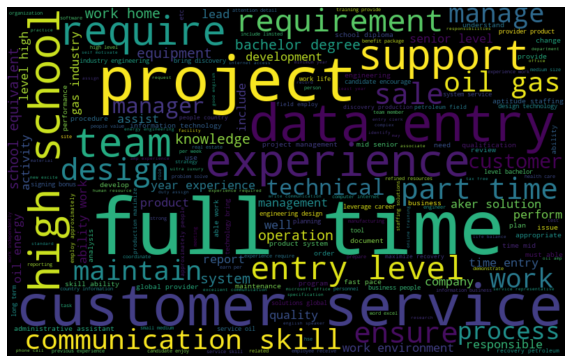

In [ ]:
# Biểu diễn wordcloud trên biểu đồ
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

Với Word Cloud bên trên, ta thấy rằng những từ như full time, customer service, data entry, experience,... có tần suất xuất hiện nhiều nhất với những thông tin tuyển dụng mang tính chất lừa đảo.

In [ ]:
# Tạo/nối chuỗi các từ trong fraudulent = 0
real_words = ' '.join([text for text in df['tidy_text'][df['fraudulent']==0]])

In [ ]:
# Tạo Wordcloud
word_cloud= WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(real_words)

(-0.5, 799.5, 499.5, -0.5)

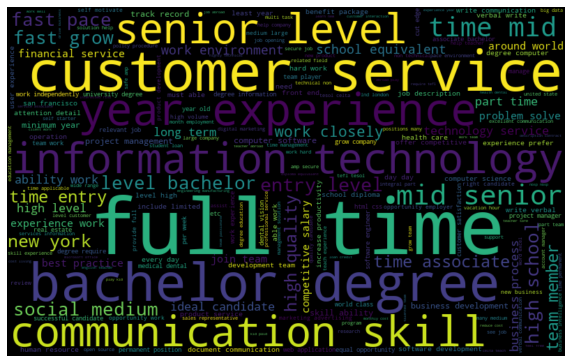

In [ ]:
# Biểu diễn wordcloud trên biểu đồ
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

Với Word Cloud bên trên, ta thấy rằng những từ như full time, customer service, bacherlor, degree, communication skill, senior level,... có tần suất xuất hiện nhiều nhất với những thông tin tuyển dụng mang tính chất không lừa đảo.

In [ ]:
#Xem số lượng dữ liệu
df.shape

(17880, 3)

In [ ]:
#Biểu diễn số lượng các bài tuyển dụng vào các nhãn
sns.set(style="darkgrid")
sns.countplot(x = "fraudulent" , data = df)

### ===>Nhìn vào biểu đồ ta thấy, dữ liệu bị mất cân bằng trầm trọng. Có 95% dữ liệu thuộc lớp 0, và chỉ có 5% thuộc lớp 1

### Các phương pháp giải quyết mất cân bằng

#### 1. Thay đổi metric:
Do dữ liệu mất cân bằng thì việc sử dụng độ đo accuracy thường sẽ không hiệu quả. Vì một mô hình ngẫu nhiên dự đoán toàn bộ là nhãn thuộc nhóm đa số sẽ cho kết quả rất cao - gần bằng 100%. Do đó, ta có thể cân nhắc tới một số metric thay thế như precision, recall, f1-score, auc,... Các chỉ số này không quá lớn để dẫn tới sự ngộ nhận độ chính xác, đồng thời chúng tập trung hơn vào việc đánh giá độ chính xác của nhóm thiểu số - nhóm mà ta muốn dự báo chính xác hơn là nhóm đa số.
Trong bài tooán này ta sẽ sử dụng độ đo f1-score

#### 2. Thay đổi thuật toán
Trong nhiều vấn đề khai thác dữ liệu, nó thì tốt cho chúng ta khi thử nhiều thuật tooán khác nhau cho dữ liệu. Nó đặt biệc có hiệu quả với những dữ liệu mất cân bằng.
Đối với phạm vi đồ án môn học này, nhóm tác giả sẽ sử dụng 3 thuật toán:
1. Logistic Regression
2. SVM
3. Random Forest

#### 3. Under Sampling
Under Sampling là việc giảm số lượng quan sát của nhóm đa số để nó trở nnê cân bằng với số quan sát của nhóm thiểu số. 
- Ưu điểm của under sampling là làm cân bằng mẫu một cách nhanh chống, dễ dàng tiến hành mà không cần đến thuật toán giả lập mẫu.
- Nhược điểm là giảm số lượng mẫu một cách đáng kể, dẫn đến tập huấn luyện mới khá nhỏ dễ dẫn đến tình trạng overfiting.

In [ ]:
from sklearn.utils import resample

In [ ]:
not_fraud_downsampled  = resample(df[df.fraudulent == 0], replace = False, n_samples = len(df[df.fraudulent == 1]), random_state=27)
downsampled  = pd.concat([not_fraud_downsampled, df[df.fraudulent == 1]])

In [ ]:
downsampled.fraudulent.value_counts()

1    866
0    866
Name: fraudulent, dtype: int64

#### 4. Over Sampling
Over Sampling là các phương pháp giúp giải quyết hiện tượng mất cân bằng mẫu bằng cách gia tăng kích thước mẫu thuộc nhóm thiểu số bằng các kỹ thuật khác nhau. Ở đây chúng ta sẽ sử dụng 2 phương pháp:
1. SMOTE - Synthetic Minority Oversampling Technique
2. ADASYN - Adaptive synthetic sampling

Cả SMOTE và ADASYN là các phương pháp sinh mẫu nhằm tăng kích thước mẫu của nhóm thiểu số trong trường hợp xảy ra mất cân bằng mẫu.
Trong đồ án môn học này, nhóm tác giả sẽ sử dụng SMOTE, ADASYN thực hiện tương tự.

###  Đối với Neural network sau khi chuẩn hóa dữ liệu chúng ta sẽ ánh xạ từng input text đầu vào thành một vector từ để làm input cho mạng. Thông thường chúng ta có 2 lựa chọn:
- Xem mỗi từ là 1 token nghĩa là chúng ta sẽ tạo ra 2 bộ từ vựng (Một chuyển đổi từ từ vựng sang số, một chuyển số tương ứng sang từ vựng). Tuy nhiên sẽ có những từ ít xuất hiện khiến cho từ điển vô cùng lớn. Để giải quyết chúng ta sẽ tạo ra token UNK – tương ứng với những từ có tần suất xuất hiện ít. Bây giờ input của mạng neural chúng ta là vector tokens sau đó sẽ được khởi tạo thành những vector số ngẫu nhiên và được đào tạo chung thông qua mạng neural.
- Word Embedding: Chúng ta sẽ ánh xạ các từ trong bộ từ vựng thành một  vector số thực có n chiều bằng cách dùng mô hình Bag of words, Skip gram hoặc có thể dùng word vector đã được train sẵn như Glove. Những từ có chung ngữ cảnh(king – queen) sẽ gần nhau trong không gian vector hơn những từ có ngữ cảnh khác biệt nhau (King-table). Các vector từ được biểu diễn theo phương pháp này thể hiện được ngữ nghĩa của các từ. Từ đó chúng ta có thể nhận ra mối quan hệ giữa các từ với nhau.
- Trong bài này, nhóm tác giả sẽ dùng phương pháp 1 tạo ra các vector tokens làm input đầu vào


### Để phân tích dữ liệu đã được xử lý bên trên, ta cần chuyển sang thành các feature. Tùy thuộc vào các sử dụng, các text feature có thể được xây dưng bằng các kỹ thuật như Bag of Words, TF-IDF và Word Embeddings

Consider a Corpus C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. 
The N tokens (words) will form a dictionary and the size of the bag-of-words matrix M will be given by D X N. 
Each row in the matrix M contains the frequency of tokens in document D(i).

Example.

D1: He is a lazy boy. She is also lazy.

D2: Smith is a lazy person.

The dictionary created would be a list of unique tokens in the corpus =[‘He’,’She’,’lazy’,’boy’,’Smith’,’person’]

Here, D=2, N=6

The matrix M of size 2 X 6 will be represented as –
    He   She   lazy   boy   Smith   person
D1  1     1     2      1      0        0
D2  0     0     1      0      1     1

In [ ]:
#min_df =2 loại bỏ những từ có lần xuất hiện bé hơn bằng 2 trong documents của text
#max_df = 0.9 loại bỏ những từ xuất hiện lớn hơn 90%
bow_vectorizer = CountVectorizer(max_df=0.9, min_df=2)

### Trong hầu hết các ngôn ngữ, có 1 số từ có xu hướng xuất hiện thường xuyên như trong tiếng anh có từ 'is', 'the',... tương tự  tiếng việt cũng có từ 'là', 'của',.. Chính vì vậy nếu chỉ xét theo tần suất xuất hiện của từng từ thì việc phân loại văn bản rất có thể cho kết quả sai dẫn đến tỉ lệ chính xác sẽ thấp. 
### TF-IDF là một phương pháp khác dựa trên phương pháp tần suất. Nhưng khác với cách tiếp cận của BOW, nó không chỉ tính đến sự xuất hiện của một từ trong 1 documents mà là toàn bộ corpus.
### TF-IDF hoạt động bằng cách xử phạt các từ phổ biến bằng cách gán cho chúng trọng lượng thấp hơn trong khi vẫn coi trọng các từ hiếm gặp trong toàn bộ corpus nhưng xuất hiện với số lượng tốt trong 1 vài documents.
### TFIDF : Term Frequency Inverse Document Frequency. 

### TF là tần số xuất hiện của 1 từ trong 1 văn bản được tính bằng (số lần xuất hiện của từ t trong văn bản d)/(số từ trong văn bản d)
## IDF là tần số nghịch của 1 từ trong văn bản. Mục đích của IDF là giảm giá trị của những từ thường xuyên xuất hiện. Do đó những từ này không còn mang nhiều ý nghĩa trong việc phân loại văn bản. Được tính bằng công thức: (tổng số văn bản trong tập D)/(số văn bản có chứa từ t)
## TFIDF = TF * IDF

## Những từ có TFIDF cao là những từ xuất hiện nhiều trong văn bản này và xuất hiện ít trong văn bản khác. Việc này giúp lọc ra những từ phổ biến và giữ lại những từ có giá trị cao (từ khóa của văn bản đó).

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import time
from datetime import datetime, timedelta

In [ ]:
df.shape

(17880, 3)

## Hold out

In [ ]:
bow = bow_vectorizer.fit_transform(df.tidy_text)

In [ ]:
bow.shape

(17880, 43882)

In [ ]:
tfidf = tfidf_vectorizer.fit_transform(df.tidy_text)

In [ ]:
tfidf.shape

(17880, 43882)

In [ ]:
#random_state = number dùng để đảm bảo phần tách luôn giống nhau khi chạy lại trong 1 chương trình
xtrain_bow, xvalid_bow, ytrain_bow, yvalid_bow = train_test_split(bow, df.fraudulent, random_state= 42, test_size=0.3,\
                                                                  stratify=df.fraudulent)

In [ ]:
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(tfidf,df.fraudulent, random_state= 42, test_size=0.3,\
                                                                          stratify=df.fraudulent)

In [ ]:
xtrain_bow.shape, ytrain_bow.shape

((12516, 43882), (12516,))

In [ ]:
xtrain_tfidf.shape, ytrain_tfidf.shape

((12516, 43882), (12516,))

In [ ]:
# sử dụng over sampling để khắc phục tình trạng imblance data
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# bow
sm = SMOTE(random_state = 42)

In [ ]:
Xtrain_bow, ytrain_bow = sm.fit_sample(xtrain_bow, ytrain_bow)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Xtrain_bow.shape, ytrain_bow.shape

((23820, 43882), (23820,))

In [ ]:
#tfidf
Xtrain_tfidf, ytrain_tfidf = sm.fit_sample(xtrain_tfidf, ytrain_tfidf)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Xtrain_tfidf.shape, ytrain_tfidf.shape

((23820, 43882), (23820,))

### LogisticRegression

In [ ]:
lreg_start = time.time()
lreg = LogisticRegression().fit(Xtrain_bow, ytrain_bow)
lreg_end = time.time()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(timedelta(seconds=round(lreg_end-lreg_start,5)))

0:00:04.279120


In [ ]:
lreg_start = time.time()
pred_bow = lreg.predict(xvalid_bow)
lreg_end = time.time()

In [ ]:
print(timedelta(seconds=round(lreg_end-lreg_start,5)))

0:00:00.009840


In [ ]:
log_bow_scores = f1_score(yvalid_bow, pred_bow)

In [ ]:
log_bow_cm = confusion_matrix(yvalid_bow, pred_bow)

Text(0.5, 1.0, 'Logistic Regression F1 Score: 0.7366548042704626')

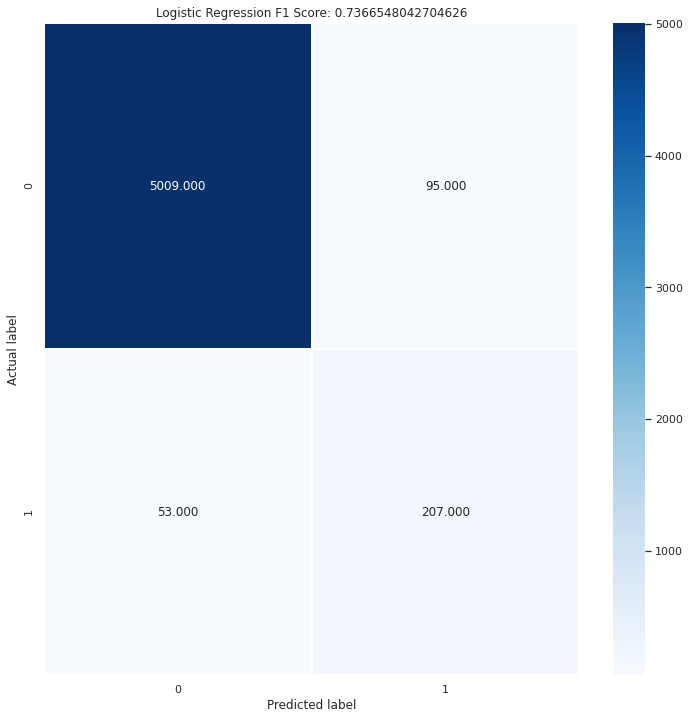

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression F1 Score: {0}'.format(log_bow_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 74%
- Có 5009 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 207 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 53 trường hợp báo nhầm (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 95 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.


## Giải quyết:

#### Giả sử ta coi lớp 0 là lớp Positive và lớp 1 là Negative. Đặt câu hỏi là làm thế nào để tăng độ báo nhầm (FPR) để giảm mức độ bỏ sót (FNR).


### Tình huống 1: Nếu chúng ta chú trọng vào việc làm thế nào để khắc phục được tình trạng BỎ SÓT bài tuyển dụng lừa đảo xuống mức tối thiểu nhất có thể.
### Giải pháp: 
Ở dây ta sẽ sử dụng predict_proba thay vì predict. Tùy thuộc ta chọn ngưỡng, nếu chọn ngưỡng là 0.2 thì mọi dự đoán có xác suất đầu ra có ngưỡng lớn hơn 0.2 sẽ được dự đoán thuộc lớp Negative - lớp 1.
Ngược lại, nếu muốn bỏ sót còn hơn báo nhầm, ta chỉ cần tăng ngưỡng lớn hơn 0.5. Khi đó các điểm dữ liệu sẽ thuộc lớp 1 - lớp Negative.

In [ ]:
#Bỏ sót
lreg_start = time.time()
prediction = lreg.predict_proba(xvalid_bow)
lreg_end = time.time()
print(timedelta(seconds=round(lreg_end-lreg_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

0:00:00.006380


In [ ]:
log_bow_scores = f1_score(prediction_int, yvalid_bow)

In [ ]:
log_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression F1 Score: {0}'.format(log_bow_scores)
plt.title(title)

Text(0.5, 1.0, 'Logistic Regression F1 Score: 0.6868044515103339')

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 68%
- Có 4951 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 216 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 153 trường hợp BÁO NHẦM  (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 44 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
- Ta thấy số lượng BỎ SÓT đã được giảm xuống - giảm 9 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán lừa đảo đúng với thực tế tăng 9 tin.

### Tình huống 2: Nếu chúng ta đặt bài toán kinh tế vào vấn đề này, ta sẽ mong muốn làm sao để công ty có thể thu đươc lợi nhuận một các tối đa, thì ta sẽ chấp nhận việc BÁO NHẦM - nghĩa là có thể bỏ qua những bài viết tuyển dụng lừa đảo.
### Giải pháp: 
Nếu muốn bỏ sót còn hơn báo nhầm, ta chỉ cần tăng ngưỡng lớn hơn 0.5, ở bài toán này nhóm tác giả chọn ngưỡng = 0.8. Khi đó các điểm dữ liệu sẽ thuộc lớp 1 - lớp Negative.

In [ ]:
#Báo nhầm
lreg_start = time.time()
prediction = lreg.predict_proba(xvalid_bow)
lreg_end = time.time()
print(timedelta(seconds=round(lreg_end-lreg_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

0:00:00.004890


In [ ]:
log_bow_scores = f1_score(prediction_int, yvalid_bow)

In [ ]:
log_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1.0, 'Logistic Regression F1 Score: 0.7895791583166332')

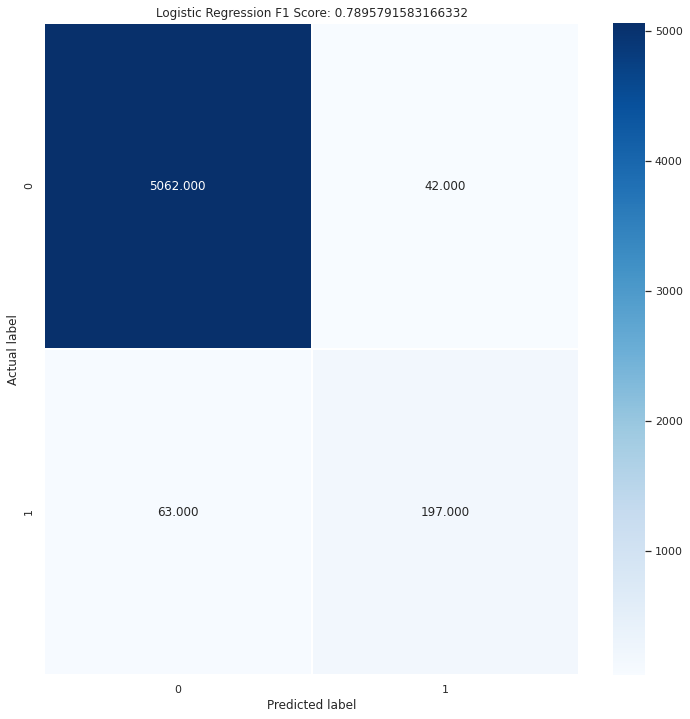

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression F1 Score: {0}'.format(log_bow_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 79%
- Có 5062 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 197 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 42 trường hợp BÁO NHẦM (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 63 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
- Ta thấy số lượng BÁO NHẦM đã được giảm xuống - giảm 53 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán không lừa đảo đúng với thực tế tăng 53 tin.

In [ ]:
#tfidf 
lreg_start = time.time()
lreg = LogisticRegression().fit(Xtrain_tfidf, ytrain_tfidf)
lreg_end = time.time()

In [ ]:
print(timedelta(seconds=round(lreg_end-lreg_start,5)))

0:00:01.809160


In [ ]:
lreg_start = time.time()
pred_tfidf = lreg.predict(xvalid_tfidf)
lreg_end = time.time()
print(timedelta(seconds=round(lreg_end-lreg_start,5)))

0:00:00.004170


In [ ]:
log_tfidf_scores = f1_score(yvalid_tfidf, pred_tfidf)

In [ ]:
log_tfidf_cm = confusion_matrix(yvalid_tfidf, pred_tfidf)

Text(0.5, 1.0, 'Logistic Regression F1 Score: 0.8226691042047533')

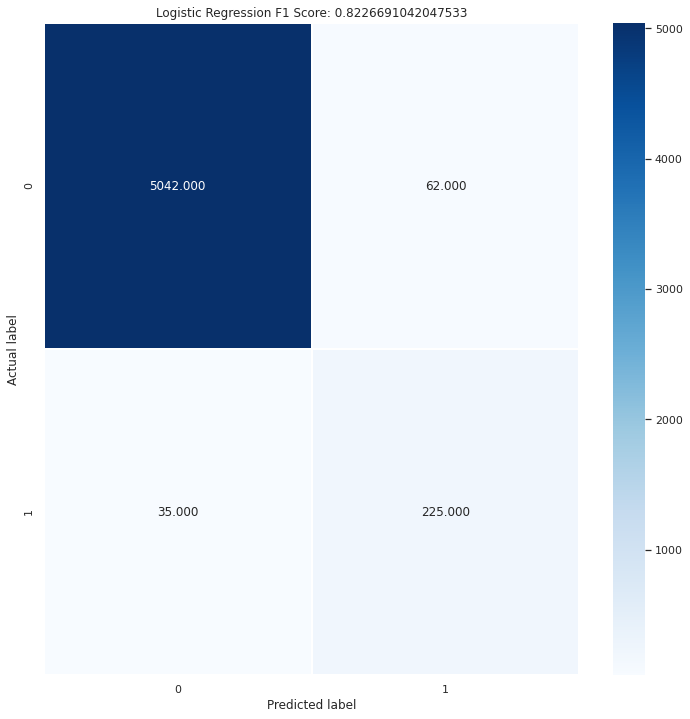

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression F1 Score: {0}'.format(log_tfidf_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 82%
- Có 5042 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 225 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 62 trường hợp BÁO NHẦM (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 35 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.

In [ ]:
# khắc phục tình trạng bỏ sót
lreg_start = time.time()
prediction = lreg.predict_proba(xvalid_tfidf)
lreg_end = time.time()
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

In [ ]:
print(timedelta(seconds=round(lreg_end-lreg_start,5)))

0:00:00.004890


In [ ]:
log_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)

In [ ]:
log_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1.0, 'Logistic Regression F1 Score: 0.5648679678530425')

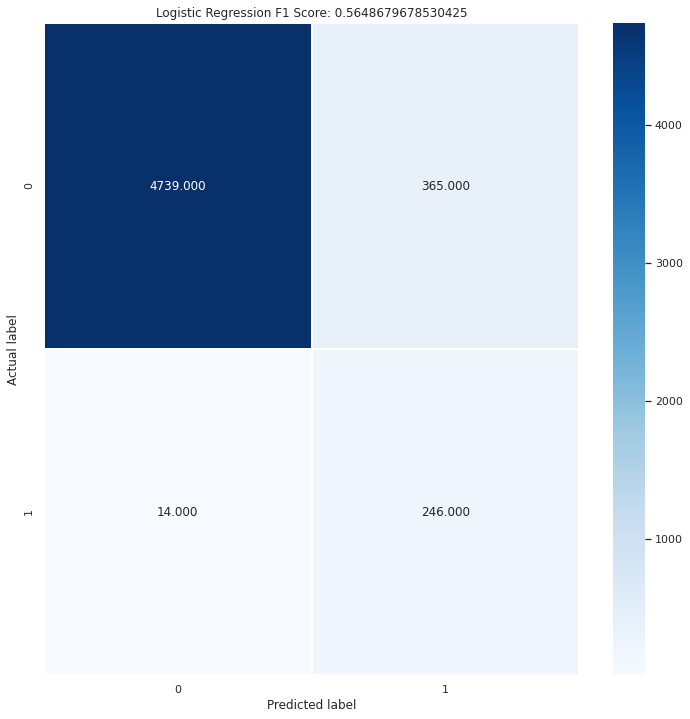

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression F1 Score: {0}'.format(log_tfidf_scores)
plt.title(title)

## Nhận xét
  Từ biểu đồ trên, ta thấy:
  - Mô hình có khả năng dự đoán chính xác 56%
  - Có 4739 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
  - Có 246 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
  - Bên cạnh đó, có 365 trường hợp BÁO NHẦM  (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 14 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
  - Ta thấy số lượng BỎ SÓT đã được giảm xuống - giảm 21 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán lừa đảo đúng với thực tế tăng 21 tin.

In [ ]:
#giảm báo nhầm
lreg_start = time.time()
prediction = lreg.predict_proba(xvalid_tfidf)
lreg_end = time.time()
print(timedelta(seconds=round(lreg_end-lreg_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

0:00:00.005600


In [ ]:
log_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)

In [ ]:
log_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1.0, 'Logistic Regression F1 Score: 0.8222222222222223')

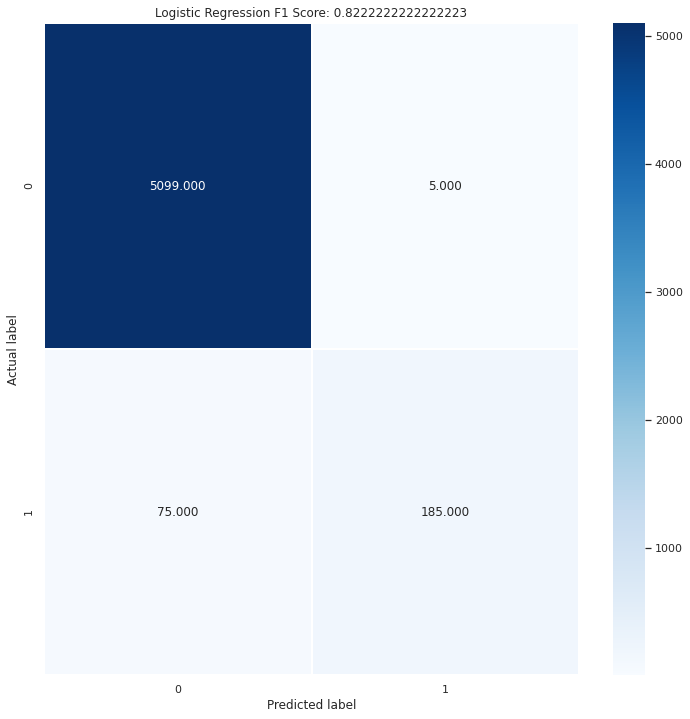

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression F1 Score: {0}'.format(log_tfidf_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 79%
- Có 5099 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 185 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 5 trường hợp BÁO NHẦM (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 75 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
- Ta thấy số lượng BÁO NHẦM đã được giảm xuống - giảm 57 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán không lừa đảo đúng với thực tế tăng 57 tin.

## Nhận xét chung cho thuật toán Logistic Regression:
Đối với thuật toán Logistic Regression, ta thấy rằng:
- Khi dự đoán với predict: BOW cho độ chính xác 74%, TFIDF là 82%.
=> Chọn TFIDF với độ dự đoán chính xác là 82% 
- Khi dự đoán với predict_proba - Trường hợp BỎ SÓT: BOW cho độ chính xác 68%, TFIDF là 56%.
=> Chọn BOW với độ chính xác là 56%.
- Khi dự đoán với predict_proba - Trường hợp BÁO NHẦM: BOW cho độ chính xác 79%, TFIDF là 82%.
=> Chọn TFIDF với độ chính xác là 82%.

### SVM

In [ ]:
#Bag of word
#Thêm parameter probability = True để thực hiện được predict_proba
svm_start = time.time()
svc = SVC(kernel='linear', C=1, probability=True).fit(Xtrain_bow, ytrain_bow)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))

0:04:44.459290


In [ ]:
svm_start = time.time()
pred_bow = svc.predict(xvalid_bow)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))

0:00:08.311580


In [ ]:
svm_bow_scores = f1_score(yvalid_bow, pred_bow)
svm_bow_cm = confusion_matrix(yvalid_bow, pred_bow)

Text(0.5, 1.0, 'SVM F1 Score: 0.7234042553191491')

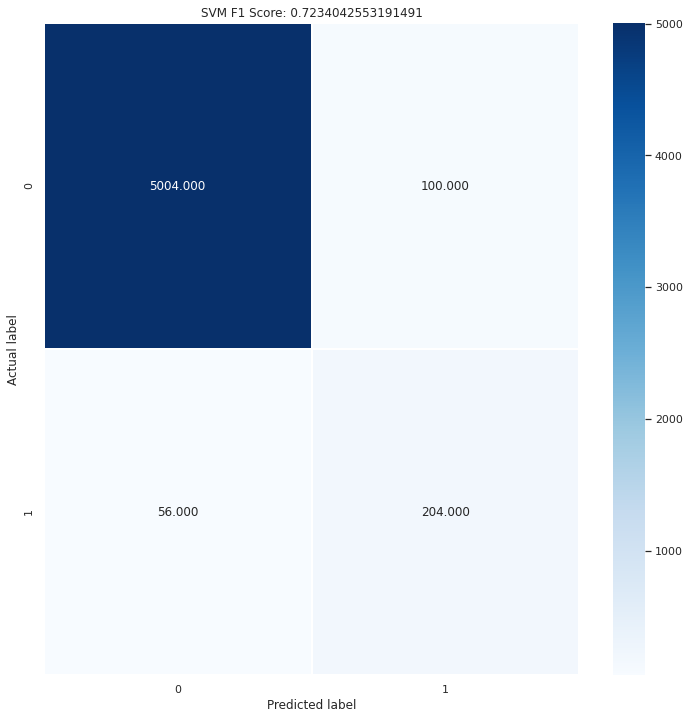

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM F1 Score: {0}'.format(svm_bow_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 72%
- Có 5004 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 204 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 100 trường hợp BÁO NHẦM (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 56 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.

In [ ]:
#Bỏ sót
svm_start = time.time()
prediction = svc.predict_proba(xvalid_bow)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

0:00:08.260430


In [ ]:
svm_bow_scores = f1_score(prediction_int, yvalid_bow)
svm_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1.0, 'SVM F1 Score: 0.6827697262479872')

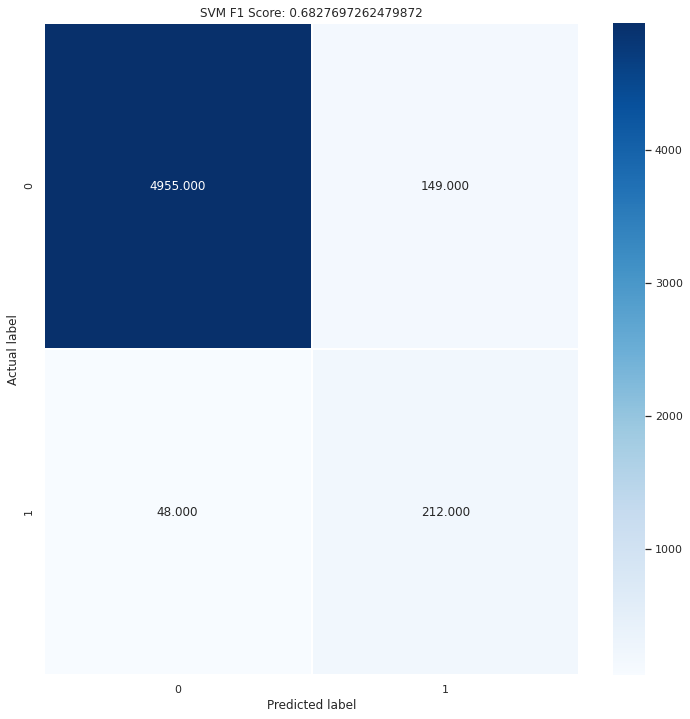

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM F1 Score: {0}'.format(svm_bow_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 68%
- Có 4955 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 212 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 149 trường hợp BÁO NHẦM  (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 48 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
- Ta thấy số lượng BỎ SÓT đã được giảm xuống - giảm 8 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán lừa đảo đúng với thực tế tăng 8 tin.

In [ ]:
#Báo nhầm
svm_start = time.time()
prediction = svc.predict_proba(xvalid_bow)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

0:00:08.350010


In [ ]:
svm_bow_scores = f1_score(prediction_int, yvalid_bow)
svm_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1.0, 'SVM F1 Score: 0.769857433808554')

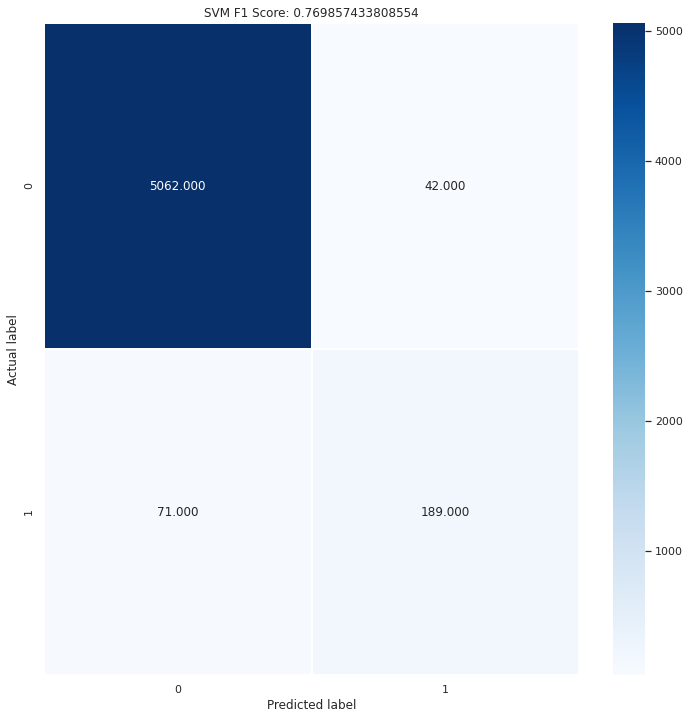

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM F1 Score: {0}'.format(svm_bow_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 79%
- Có 5062 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 190 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 42 trường hợp BÁO NHẦM (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 70 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
- Ta thấy số lượng BÁO NHẦM đã được giảm xuống - giảm 58 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán không lừa đảo đúng với thực tế tăng 58 tin.

In [ ]:
#TFIDF
svm_start = time.time()
svc = SVC(kernel='linear', C=1, probability=True).fit(Xtrain_tfidf, ytrain_tfidf)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))

0:10:01.402620


In [ ]:
svm_start = time.time()
pred_tfidf = svc.predict(xvalid_tfidf)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))

0:00:21.776900


In [ ]:
svm_tfidf_scores = f1_score(yvalid_tfidf, pred_tfidf)
svm_tfidf_cm = confusion_matrix(yvalid_tfidf, pred_tfidf)

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM F1 Score: {0}'.format(svm_tfidf_scores)
plt.title(title)

Text(0.5, 1.0, 'SVM F1 Score: 0.8729508196721311')

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 87%
- Có 5089 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 213 thông tin tuyển dụng dự đoán lớp (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 15 trường hợp BÁO NHẦM (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 47 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.

In [ ]:
#Bỏ sót
svm_start = time.time()
prediction = svc.predict_proba(xvalid_tfidf)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

0:00:21.952590


In [ ]:
svm_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)
svm_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1.0, 'SVM F1 Score: 0.8595744680851064')

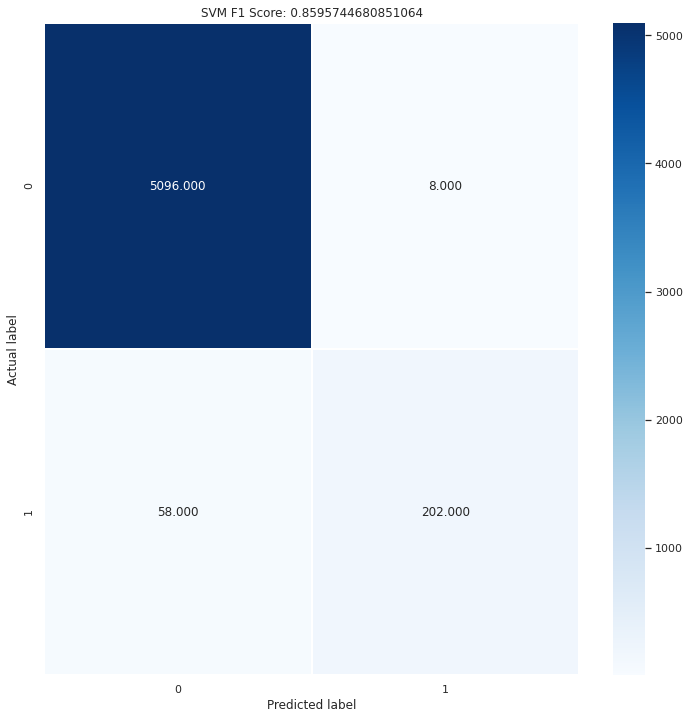

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM F1 Score: {0}'.format(svm_tfidf_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 86%
- Có 5096 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 204 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 8 trường hợp BÁO NHẦM  (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 56 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
- Ta thấy số lượng BỎ SÓT đã được giảm xuống - giảm 8 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán lừa đảo đúng với thực tế tăng 8 tin.

In [ ]:
#Báo nhầm
svm_start = time.time()
prediction = svc.predict_proba(xvalid_tfidf)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

0:00:21.880260


In [ ]:
svm_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)
svm_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1.0, 'SVM F1 Score: 0.8329621380846325')

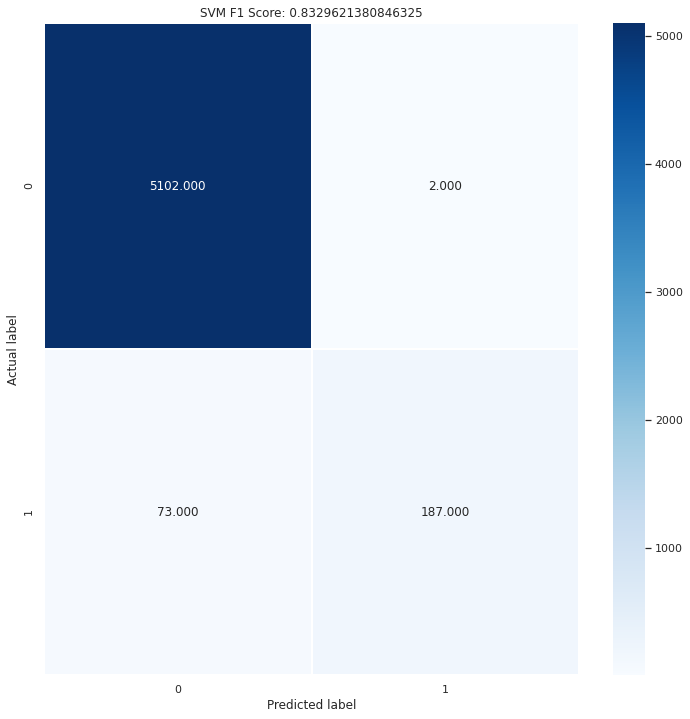

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM F1 Score: {0}'.format(svm_tfidf_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 83%
- Có 5102 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 187 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 2 trường hợp BÁO NHẦM (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 73 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
- Ta thấy số lượng BÁO NHẦM đã được giảm xuống - giảm 13 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán không lừa đảo đúng với thực tế tăng 13 tin.

## Nhận xét chung cho thuật toán SVM: 
Đối với thuật toán SVM, ta thấy rằng:
- Khi dự đoán với predict: BOW cho độ chính xác 72%, TFIDF là 87%.
=> Chọn TFIDF với độ dự đoán chính xác là 87% 
- Khi dự đoán với predict_proba - Trường hợp BỎ SÓT: BOW cho độ chính xác 68%, TFIDF là 86%.
=> Chọn TFIDF với độ chính xác là 56%.
- Khi dự đoán với predict_proba - Trường hợp BÁO NHẦM: BOW cho độ chính xác 77%, TFIDF là 83%.
=> Chọn TFIDF với độ chính xác là 83%.

### Random Forest

In [ ]:
#BOW
rf_start = time.time()
rf = RandomForestClassifier(n_estimators=800, random_state=11).fit(Xtrain_bow, ytrain_bow) 
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

0:03:30.044370


In [ ]:
rf_start = time.time()
pred_bow = rf.predict(xvalid_bow)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

0:00:05.158620


In [ ]:
rf_bow_scores = f1_score(yvalid_bow, pred_bow)
rf_bow_cm = confusion_matrix(yvalid_bow, pred_bow)

Text(0.5, 1.0, 'Random Forest F1 Score: 0.7239999999999999')

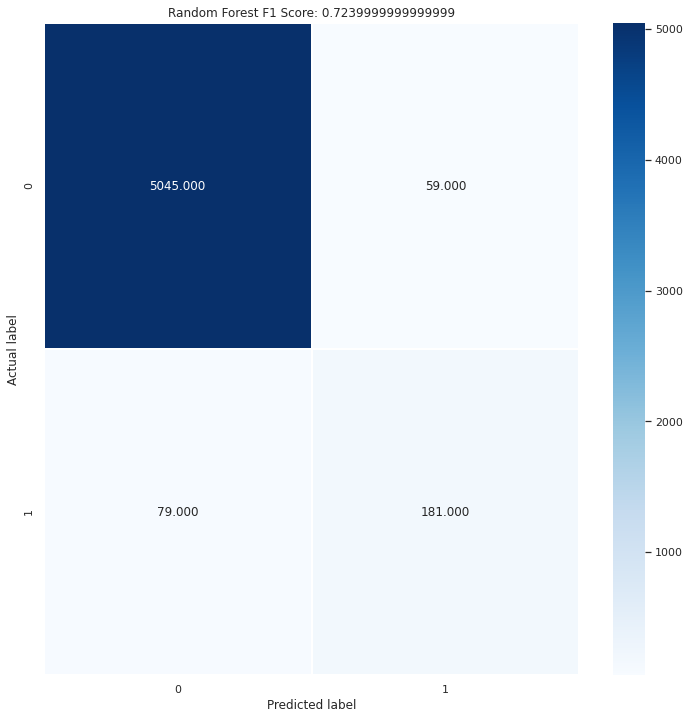

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest F1 Score: {0}'.format(rf_bow_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 72%
- Có 5044 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 181 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 60 trường hợp BÁO NHẦM (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 79 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.

In [ ]:
#Bỏ sót
rf_start = time.time()
prediction = rf.predict_proba(xvalid_bow)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

0:00:05.126880


In [ ]:
rf_bow_scores = f1_score(prediction_int, yvalid_bow)
rf_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1.0, 'Random Forest F1 Score: 0.56')

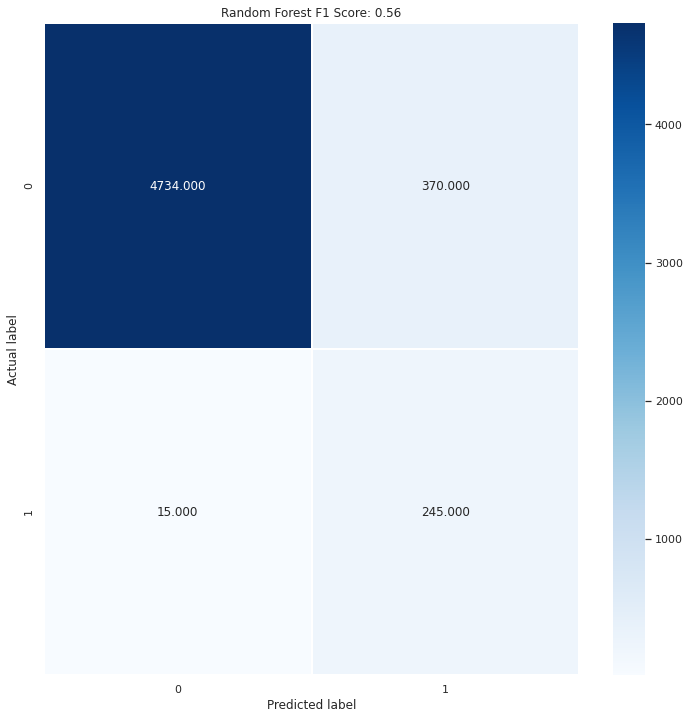

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest F1 Score: {0}'.format(rf_bow_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 56%
- Có 4734 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 246 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 370 trường hợp BÁO NHẦM  (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 14 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
- Ta thấy số lượng BỎ SÓT đã được giảm xuống - giảm 65 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán lừa đảo đúng với thực tế tăng 65 tin.

In [ ]:
#Báo nhầm
rf_start = time.time()
prediction = rf.predict_proba(xvalid_bow)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

0:00:05.148600


In [ ]:
rf_bow_scores = f1_score(prediction_int, yvalid_bow)
rf_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1.0, 'Random Forest F1 Score: 0.6253229974160207')

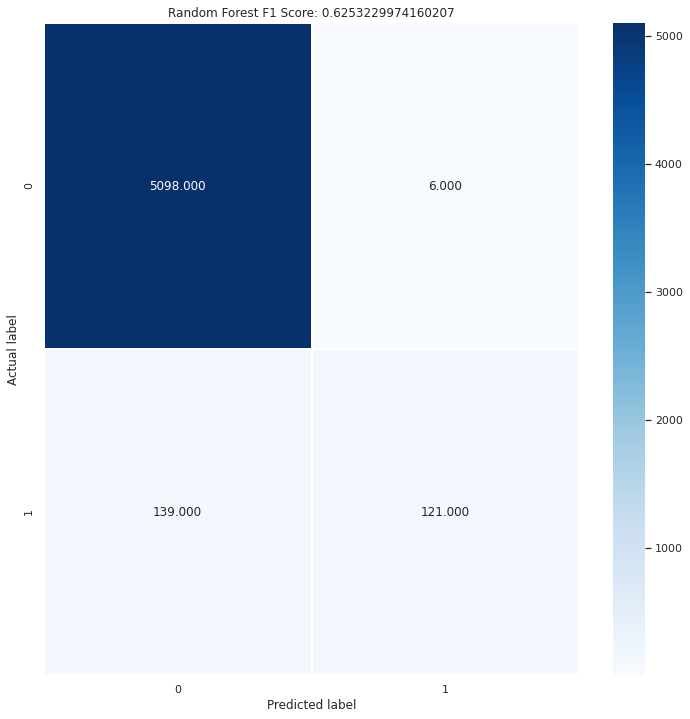

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest F1 Score: {0}'.format(rf_bow_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 61%
- Có 5098 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 118 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 6 trường hợp BÁO NHẦM (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 142 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
- Ta thấy số lượng BÁO NHẦM đã được giảm xuống - giảm 364 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán không lừa đảo đúng với thực tế tăng 364 tin.

In [ ]:
#TFIDF
rf_start = time.time()
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(Xtrain_tfidf, ytrain_tfidf)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

0:01:27.157400


In [ ]:
rf_start = time.time()
pred_tfidf = rf.predict(xvalid_tfidf)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

0:00:02.601840


In [ ]:
rf_tfidf_scores = f1_score(yvalid_tfidf, pred_tfidf)
rf_tfidf_cm = confusion_matrix(yvalid_tfidf, pred_tfidf)

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest F1 Score: {0}'.format(rf_tfidf_scores)
plt.title(title)

Text(0.5, 1.0, 'Random Forest F1 Score: 0.7832167832167831')

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 78%
- Có 5103 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 168 thông tin tuyển dụng dự đoán lớp (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 92 trường hợp BÁO NHẦM (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 1 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.

In [ ]:
#Bỏ sót
rf_start = time.time()
prediction = rf.predict_proba(xvalid_tfidf)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

0:00:02.613600


In [ ]:
rf_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)
rf_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1.0, 'Random Forest F1 Score: 0.7210682492581602')

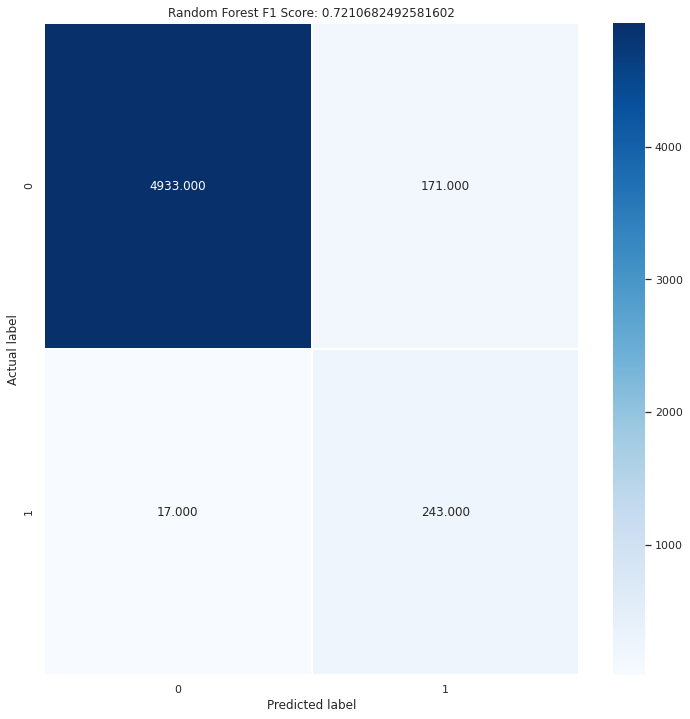

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest F1 Score: {0}'.format(rf_tfidf_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 72%
- Có 4933 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 243 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 171 trường hợp BÁO NHẦM  (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 17 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
- Ta thấy số lượng BỎ SÓT đã được giảm xuống - giảm 75 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán lừa đảo đúng với thực tế tăng 75 tin.

In [ ]:
#Báo nhầm
rf_start = time.time()
prediction = rf.predict_proba(xvalid_tfidf)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

0:00:02.657070


In [ ]:
rf_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)
rf_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1.0, 'Random Forest F1 Score: 0.631578947368421')

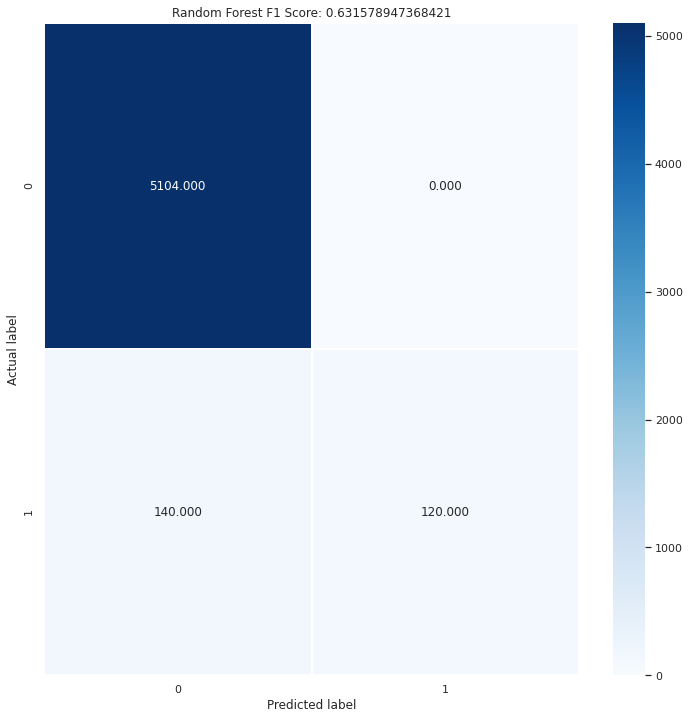

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest F1 Score: {0}'.format(rf_tfidf_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Mô hình có khả năng dự đoán chính xác 63%
- Có 5104 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 120 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 0 trường hợp BÁO NHẦM (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 140 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.
- Ta thấy số lượng BÁO NHẦM đã được giảm xuống - giảm 1 tin. Đồng nghĩa với việc thông tin tuyển dụng được dự đoán không lừa đảo đúng với thực tế tăng 1 tin.

## Nhận xét chung cho thuật toán Random Forest: 
Đối với thuật toán Random Forest, ta thấy rằng:
- Khi dự đoán với predict: BOW cho độ chính xác 72%, TFIDF là 78%.
=> Chọn TFIDF với độ dự đoán chính xác là 78% 
- Khi dự đoán với predict_proba - Trường hợp BỎ SÓT: BOW cho độ chính xác 56%, TFIDF là 72%.
=> Chọn TFIDF với độ chính xác là 72%.
- Khi dự đoán với predict_proba - Trường hợp BÁO NHẦM: BOW cho độ chính xác 61%, TFIDF là 63%.
=> Chọn TFIDF với độ chính xác là 63%.

#Nhận xét chung:
Với mục tiêu là tốc độ train nhanh cùng với độ chính xác tốt, ta có:
##Predict:
- Khi dự đoán predict với BOW, ta thấy thuật toán Logistic cho kết quả dự đoán cao nhất(74%) và thời gian training(3.25s) cũng như thời gian predict(0.01s) cũng nhanh hơn 2 thuật toán còn lại. => Chọn Logistic Regression.
- Khi dự đoán predict với TFIDF, ta thấy thuật toán SVM cho kết quả dự đoán cao nhất(87%) nhưng thời gian training cao(14.12m) cũng như thời gian predict(31.5s). Trong khi đó, ta có thuật toán Logistic, có tốc độ train với 3.25s và thời gian predict là 0.007s. => Chọn thuật toán Logistic Regression trong trường hợp này.
##Predict_proba - BỎ SÓT:
- Khi dự đoán predict_proba với BOW, ta thấy thuật toán Logistic cho kết quả dự đoán cao nhất(69%) và thời gian training(3.25s) cũng như thời gian predict(0.09s) cũng nhanh hơn 2 thuật toán còn lại.=> Chọn Logistic Regression.
- Khi dự đoán predict_proba với TFIDF, ta thấy thuật toán SVM cho kết quả dự đoán cao nhất(86%) nhưng thời gian training cao(14.12m) cũng như thời gian predict(31.2s). Trong khi đó, ta có thuật toán Random Forest, có tốc độ train với 1.52m và thời gian predict là 0.19s. => Chọn thuật toán Random Forest trong trường hợp này.
##Predict_proba - BÁO NHẦM:
- Khi dự đoán predict_proba với BOW, ta thấy thuật toán Logistic cho kết quả dự đoán cao nhất(79%) và thời gian training(3.25s) cũng như thời gian predict(0.01s) cũng nhanh hơn 2 thuật toán còn lại.=> Chọn Logistic Regression.
- Khi dự đoán predict_proba với TFIDF, ta thấy thuật toán SVM cho kết quả dự đoán cao nhất(83%) nhưng thời gian training cao(14.12m) cũng như thời gian predict(31.4s). Trong khi đó, ta có thuật toán Logistic Regression, có tốc độ train với 0.013s và thời gian predict là 0.0097s. => Chọn thuật toán Logistic Regression trong trường hợp này.


# MỞ RỘNG:
## Phân chia dữ liệu bằng Phương pháp Cross validation - StratifiedKFord

Phương pháp Hold out phân chia dữ liệu thành 2 tập độc lập, tuy nhiên các mẫu có thể không đại diện cho toàn bộ dữ liệu. Ta có thể cải tiến bằng cách dùng phương pháp lấy mẫu sao cho mỗi lớp được phân bố đều trong cả 2 tập train và valid hay còn gọi là Cross Validation. Cross-validation là kỹ thuật dùng để chia dữ liệu giữa các training sets và validation sets. Trên mỗi Cross-validation điển hình (K-Fold), việc này được thực hiện ngẫu nhiên.

 Nhưng trên Stratified Cross-validation việc này được thực hiện xấp xỉ nhau. Với ví dụ bài toán này, ta sử dụng Stratified thì sẽ có tỉ lệ tương tự giữa train và valid. Ngược lại nếu ta dùng cross-validatio điển hình, trường hợp xấu nhất thì ta sẽ không thấy lớp 1 trong valid set.

- fit() tính toán mean và std để sử dụng cho scale sau này.
- transform() sử dụng mean và std từ fit() để auto scale data (lấy tất cả giá trị trừ cho mean và chia cho std).
- fit_transform() fix cả 2 cái trên.
- Với trainning set, ta sử dụng fit_transform vì ta cần tính mean và std và sau đó sử dụng chúng để auto scale dữ liệu.
- Với testing set, ta đã có sẳn mean và std nên chỉ cần transform nó.


In [ ]:
from sklearn.model_selection import StratifiedKFold
import datetime

1 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Time training of Fold 1:0:00:04.473670
Time predict of Fold 1:0:00:00.003840
F1_score of Fold 1: 0.7630057803468208


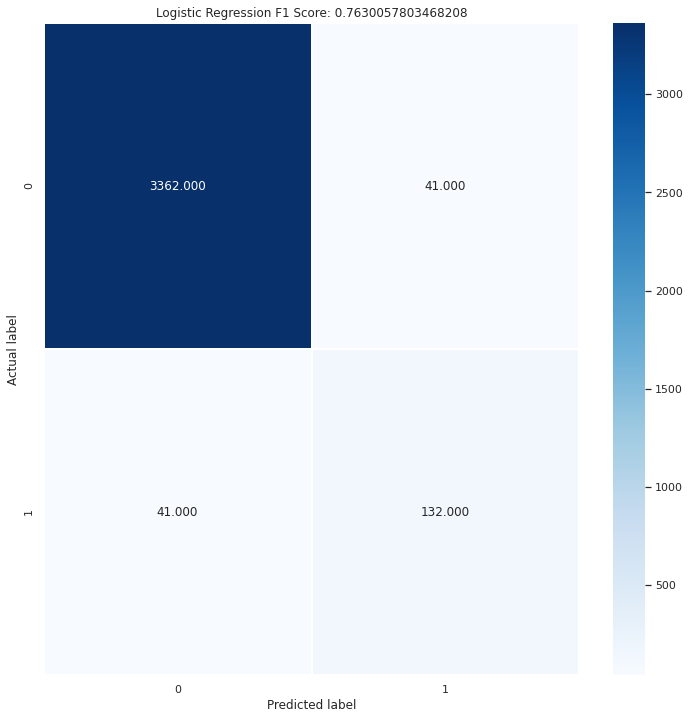

2 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Time training of Fold 2:0:00:04.469210
Time predict of Fold 2:0:00:00.003570
F1_score of Fold 2: 0.7421052631578947


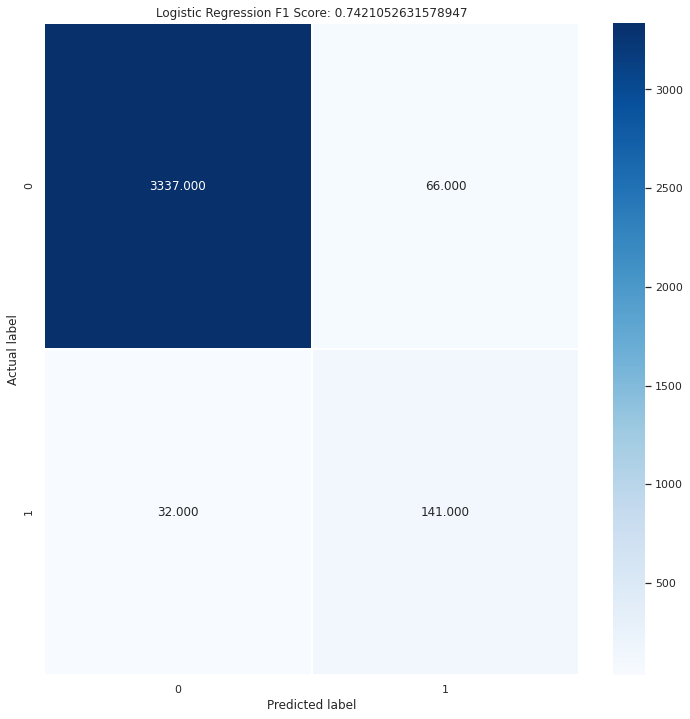

3 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Time training of Fold 3:0:00:04.458960
Time predict of Fold 3:0:00:00.003430
F1_score of Fold 3: 0.7241379310344828


4 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Time training of Fold 4:0:00:04.532930
Time predict of Fold 4:0:00:00.003440
F1_score of Fold 4: 0.7365728900255754


5 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Time training of Fold 5:0:00:04.523380
Time predict of Fold 5:0:00:00.003510
F1_score of Fold 5: 0.7545219638242894


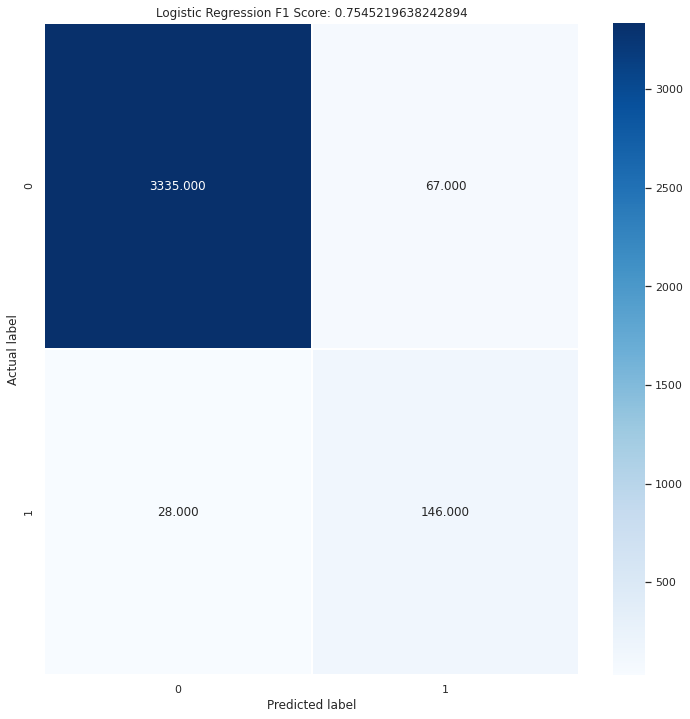

Total time runing: 0:01:35.801450
Mean f1_score = 0.74


In [ ]:
#bow - Logistic Regression
start = time.time()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = []  
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = bow_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = bow_vectorizer.transform(xvalid_bow)    
    

    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)
    
    lreg_start = time.time()
    lreg = LogisticRegression().fit(Xtrain_bow, Ytrain_bow)
    lreg_end = time.time()
    time_train = timedelta(seconds=round(lreg_end - lreg_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    lreg_start = time.time()
    preds = lreg.predict(test_X_vec)
    lreg_end = time.time()
    time_pred = timedelta(seconds=round(lreg_end - lreg_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    lreg_cm = metrics.confusion_matrix(yvalid_bow, preds)

    plt.figure(figsize=(12,12))
    sns.heatmap(lreg_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Logistic Regression F1 Score: {0}'.format(scores)
    plt.title(title)
    plt.show()

    cv_scores.append(scores)
    i += 1

end = time.time()
print('Total time runing:', timedelta(seconds=round(end - start,5)))
print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))

## Nhận xét:
- Tổng thời gian chạy là 1.19s.
- Mean của độ đo f1-score cho 5 fold là 74% bằng so với phương pháp Hold out.
- Thời gian train và predict cho từng Fold cũng xấp xỉ phương pháp Hold out. 

1 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 1:0:00:02.495700
Time predict of Fold 1:0:00:00.002830
F1_score of Fold 1: 0.7833333333333333


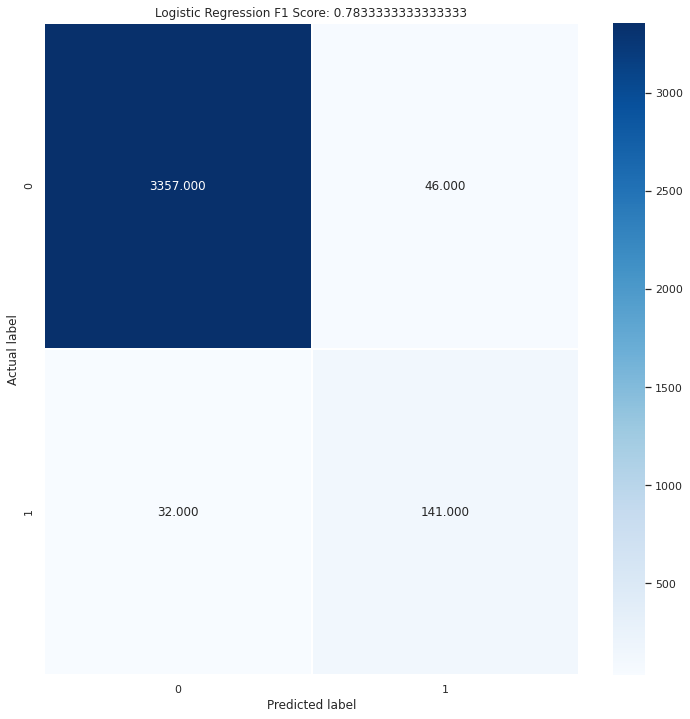

2 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 2:0:00:02.192540
Time predict of Fold 2:0:00:00.002570
F1_score of Fold 2: 0.8291316526610644


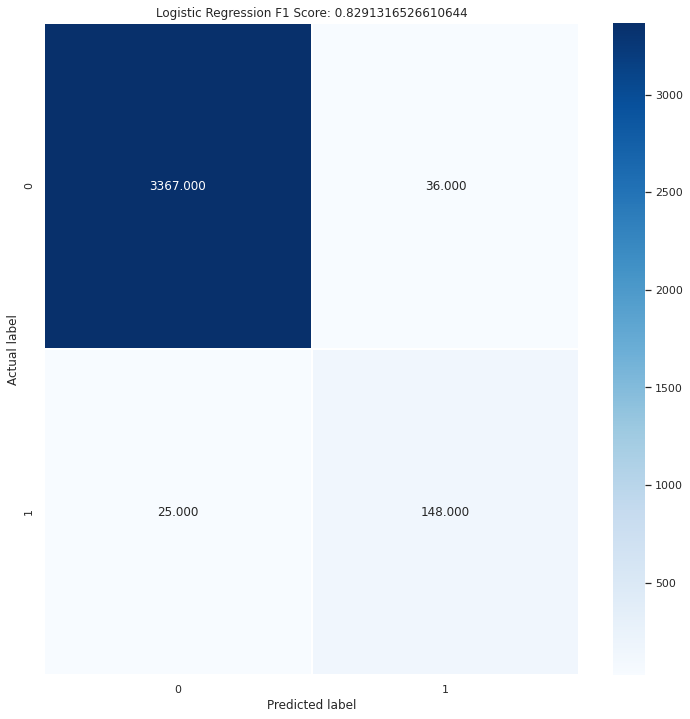

3 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 3:0:00:02.551640
Time predict of Fold 3:0:00:00.002960
F1_score of Fold 3: 0.7727272727272726


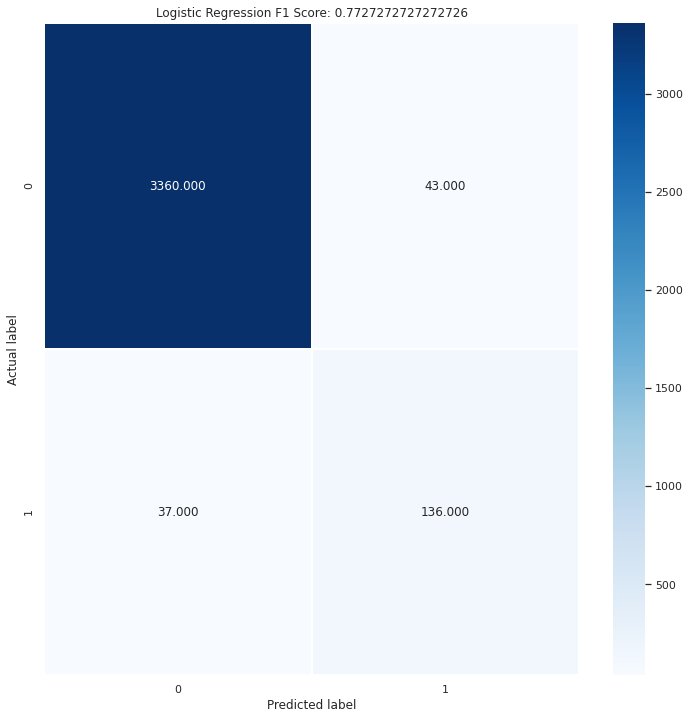

4 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 4:0:00:02.731900
Time predict of Fold 4:0:00:00.002510
F1_score of Fold 4: 0.8108108108108107


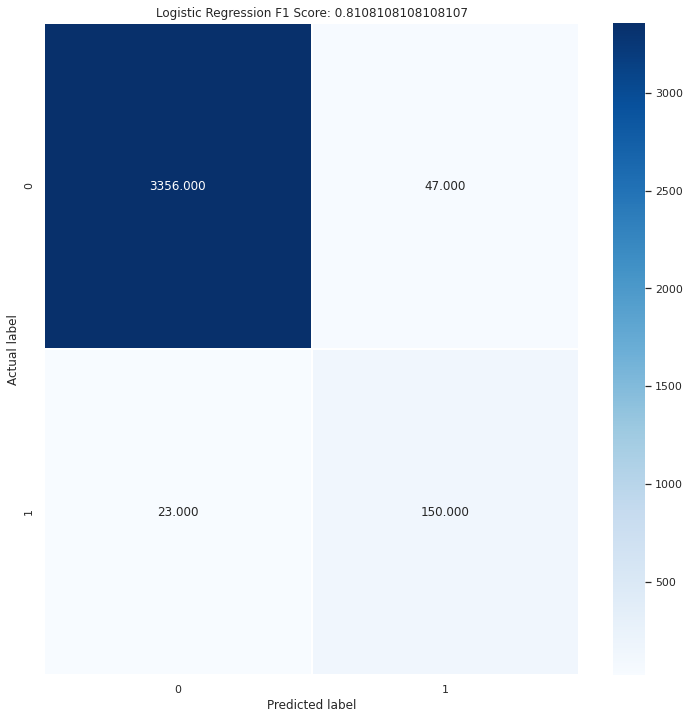

5 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 5:0:00:02.831730
Time predict of Fold 5:0:00:00.002570
F1_score of Fold 5: 0.7798408488063661


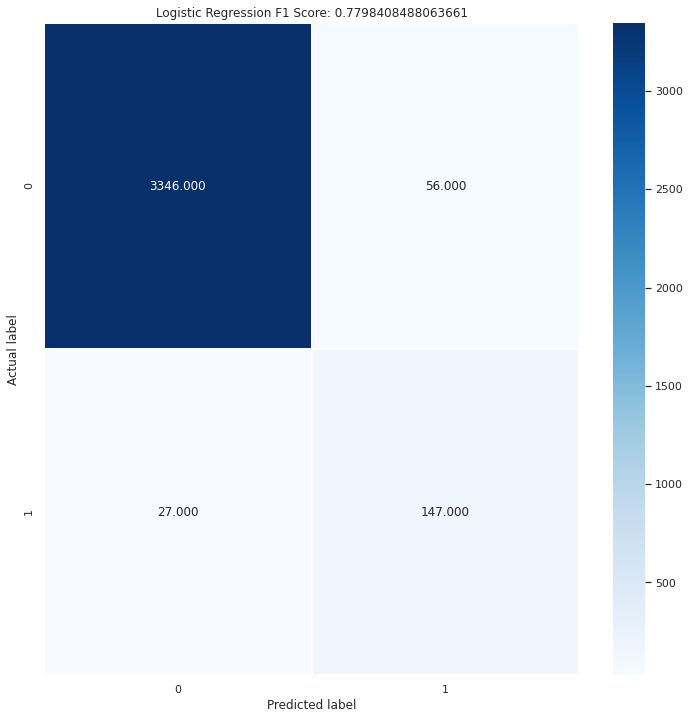

Total time runing: 0:01:44.770590
Mean f1_score = 0.80


In [ ]:
#tfidf - Logistic Regression
start = time.time()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = []    
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = tfidf_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = tfidf_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)
    
    lreg_start = time.time()
    lreg = LogisticRegression().fit(Xtrain_bow, Ytrain_bow)
    lreg_end = time.time()
    time_train = timedelta(seconds=round(lreg_end - lreg_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    lreg_start = time.time()
    preds = lreg.predict(test_X_vec)
    lreg_end = time.time()
    time_pred = timedelta(seconds=round(lreg_end - lreg_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    lreg_cm = metrics.confusion_matrix(yvalid_bow, preds)

    plt.figure(figsize=(12,12))
    sns.heatmap(lreg_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Logistic Regression F1 Score: {0}'.format(scores)
    plt.title(title)
    plt.show()

    cv_scores.append(scores)
    i += 1

end = time.time()
print('Total time runing:', timedelta(seconds=round(end - start,5)))
print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))

#Nhận xét:
- Tổng thời gian chạy là 1.19s.
- Mean của độ đo f1-score cho 5 fold là 80% thấp hơn so với phương pháp Hold out 82%.
- Thời gian train và predict cho từng Fold chậm hơn phương pháp Hold out 1 ít nhưng không đáng kể. 

1 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 1:0:05:40.110640
Time predict of Fold 1:0:00:05.574690
F1_score of Fold 1: 0.7401129943502825


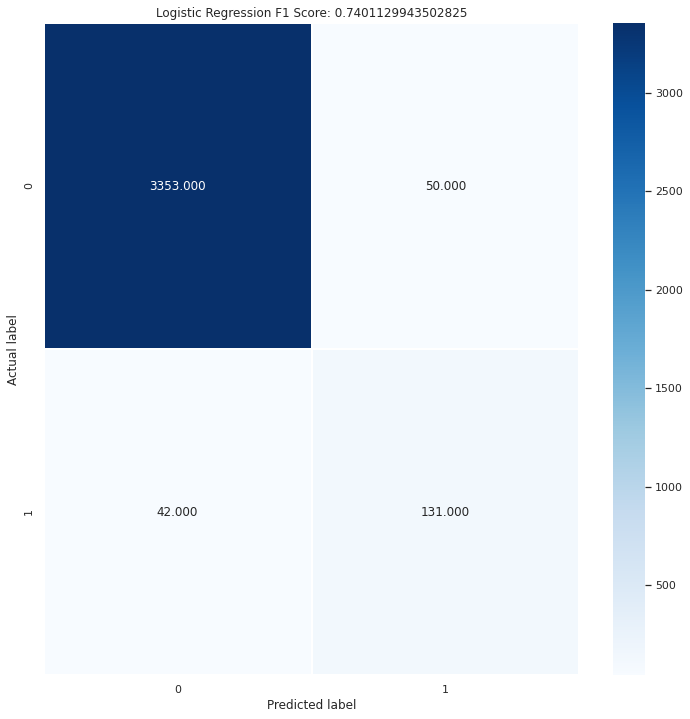

2 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 2:0:05:48.683560
Time predict of Fold 2:0:00:05.606350
F1_score of Fold 2: 0.7310704960835509


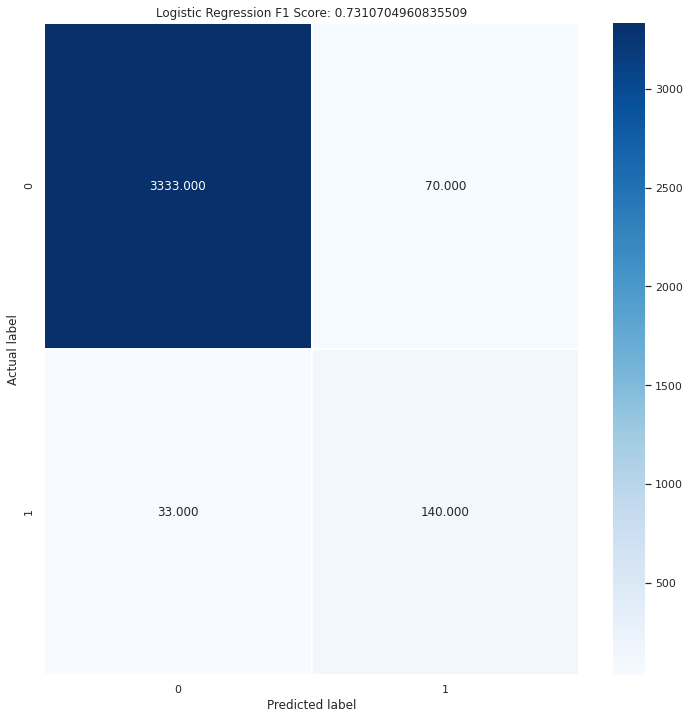

3 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 3:0:05:34.091210
Time predict of Fold 3:0:00:05.504700
F1_score of Fold 3: 0.6797752808988764


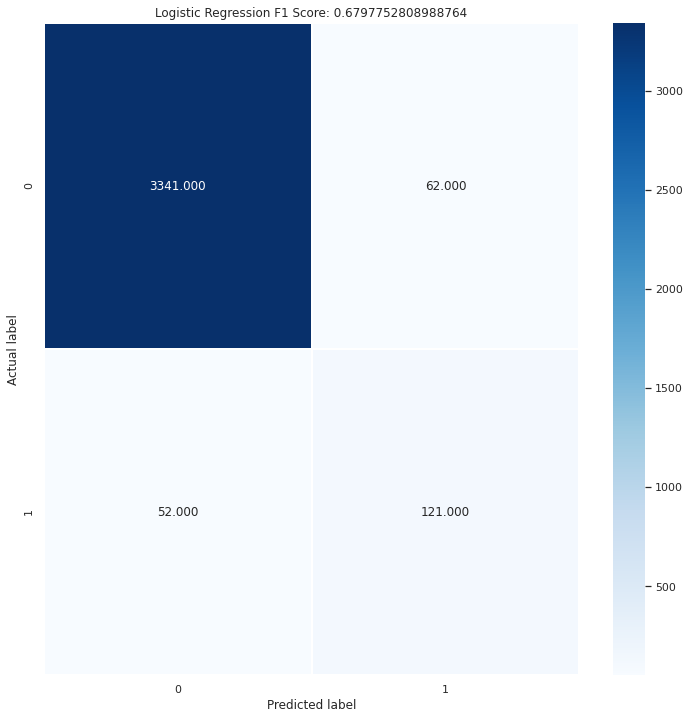

4 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 4:0:05:50.673870
Time predict of Fold 4:0:00:05.601730
F1_score of Fold 4: 0.74934036939314


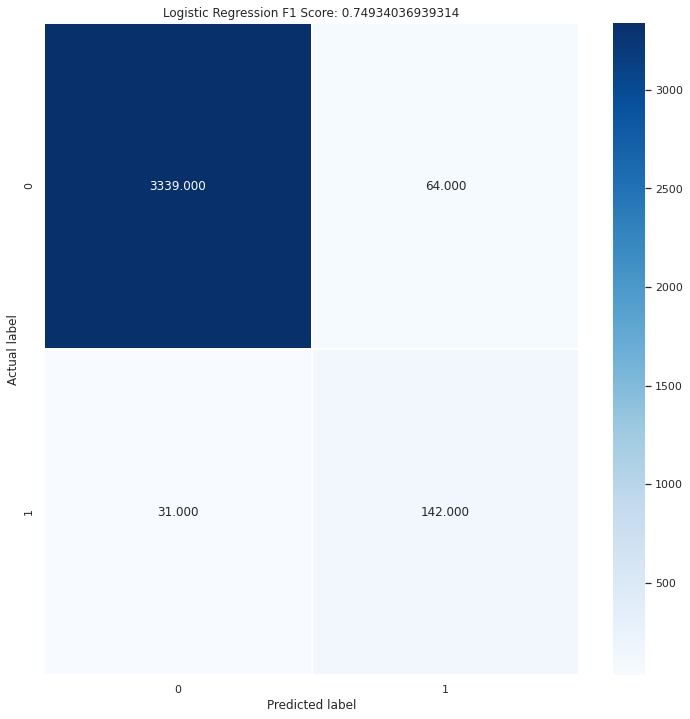

5 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 5:0:06:00.060410
Time predict of Fold 5:0:00:05.859680
F1_score of Fold 5: 0.7362924281984333


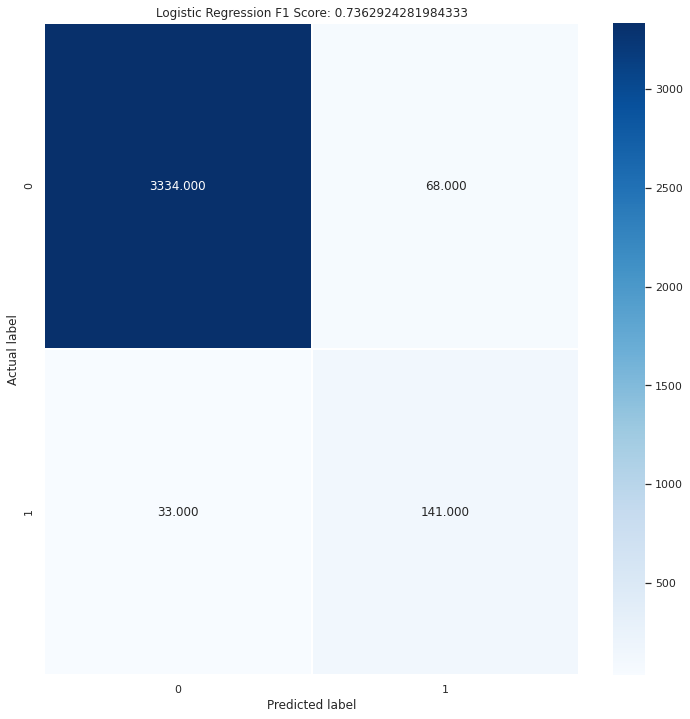

Total time runing: 0:30:35.516550
Mean f1_score = 0.73


In [ ]:
#bow - SVM
start = time.time()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = []   
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = bow_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = bow_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)

    svm_start = time.time()
    svc = SVC(kernel='linear', C=1, probability=True).fit(Xtrain_bow, Ytrain_bow)
    svm_end = time.time()
    time_train = timedelta(seconds=round(svm_end - svm_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    svm_start = time.time()
    preds = svc.predict(test_X_vec)
    svm_end = time.time()
    time_pred = timedelta(seconds=round(svm_end - svm_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    svm_cm = metrics.confusion_matrix(yvalid_bow, preds)

    plt.figure(figsize=(12,12))
    sns.heatmap(svm_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Logistic Regression F1 Score: {0}'.format(scores)
    plt.title(title)
    plt.show()

    cv_scores.append(scores)
    i += 1

end = time.time()
print('Total time runing:', timedelta(seconds=round(end - start,5)))
print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))

#Nhận xét:
- Tổng thời gian chạy là 39.29m.
- Mean của độ đo f1-score cho 5 fold là 73% cao hơn so với phương pháp Hold out 72%.
- Thời gian train cao hơn phương pháp Hold out 1 phút hơn.
- Thời gian predict thấp hơn phương pháp Hold out gần 1/2.



1 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 1:0:16:47.493860
Time predict of Fold 1:0:00:20.141090
F1_score of Fold 1: 0.8282208588957055


2 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 2:0:18:52.138120
Time predict of Fold 2:0:00:19.655970
F1_score of Fold 2: 0.8580246913580247


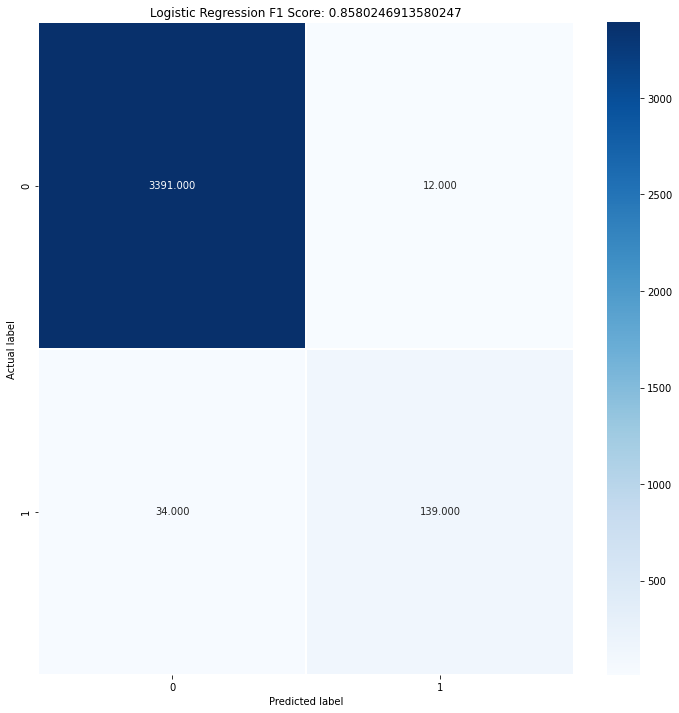

3 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 3:0:16:00.162790
Time predict of Fold 3:0:00:19.272310
F1_score of Fold 3: 0.8113207547169811


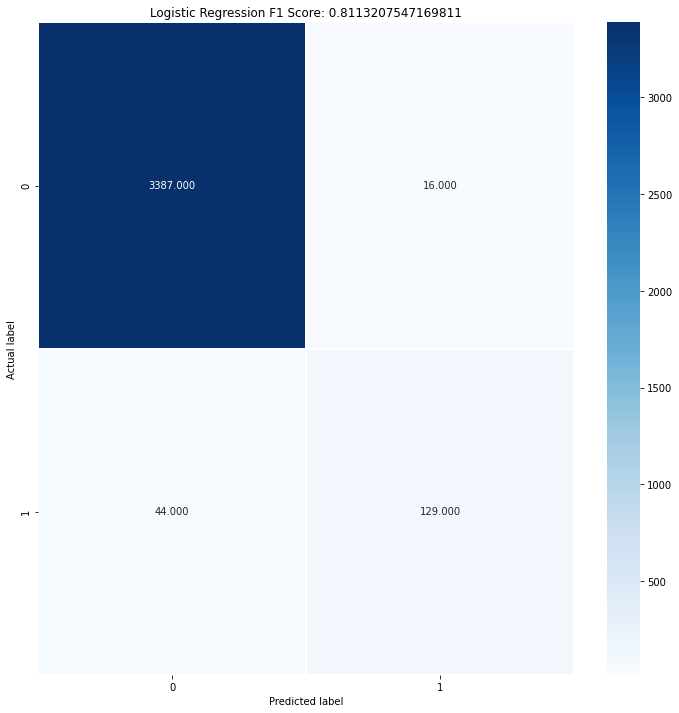

4 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 4:0:17:44.954540
Time predict of Fold 4:0:00:21.314890
F1_score of Fold 4: 0.8511904761904763


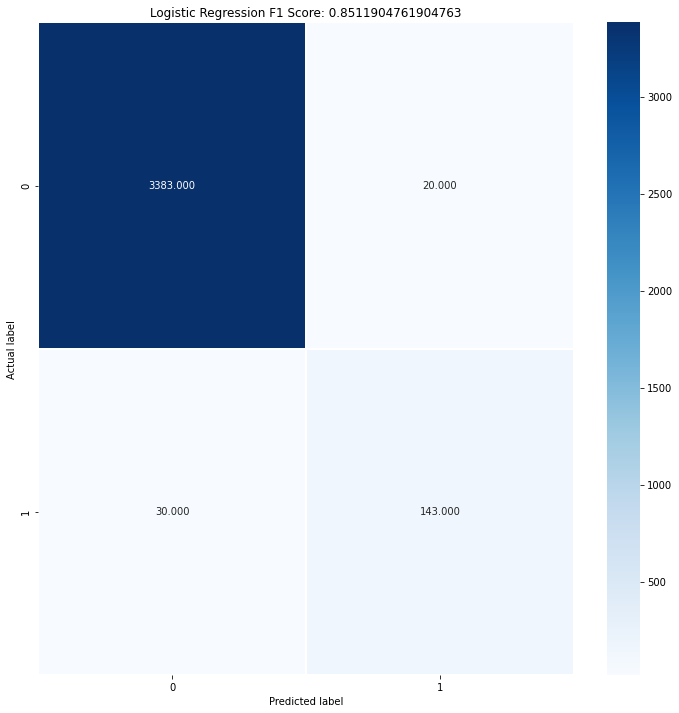

5 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 5:0:17:23.022380
Time predict of Fold 5:0:00:20.504370
F1_score of Fold 5: 0.8454810495626823


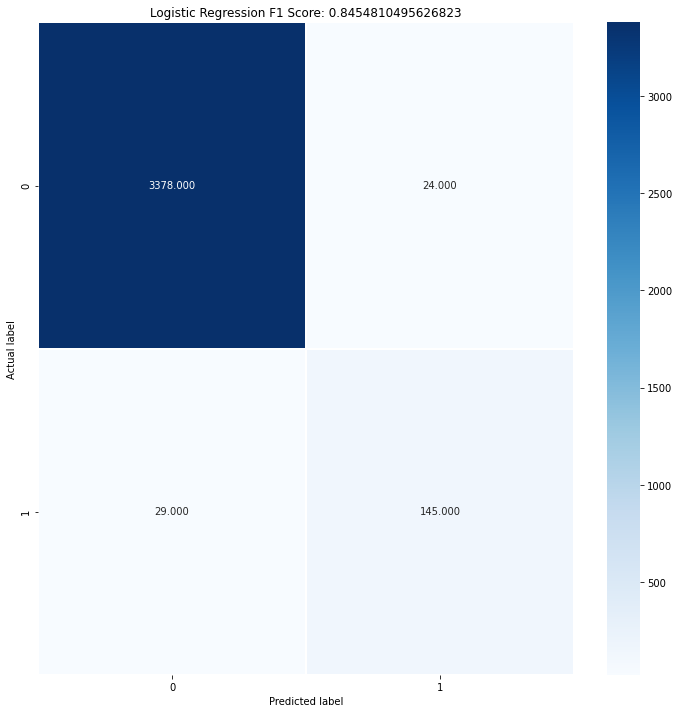

Total time runing: 1:29:46.717220
Mean f1_score = 0.84


In [ ]:
#tfidf - SVM
start = time.time()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = []  
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = tfidf_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = tfidf_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)

    svm_start = time.time()
    svc = SVC(kernel='linear', C=1, probability=True).fit(Xtrain_bow, Ytrain_bow)
    svm_end = time.time()
    time_train = timedelta(seconds=round(svm_end - svm_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    svm_start = time.time()
    preds = svc.predict(test_X_vec)
    svm_end = time.time()
    time_pred = timedelta(seconds=round(svm_end - svm_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    svm_cm = metrics.confusion_matrix(yvalid_bow, preds)

    plt.figure(figsize=(12,12))
    sns.heatmap(svm_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Logistic Regression F1 Score: {0}'.format(scores)
    plt.title(title)
    plt.show()

    cv_scores.append(scores)
    i += 1

end = time.time()
print('Total time runing:',timedelta(seconds=round(end - start,5)))
print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))

#Nhận xét:
- Tổng thời gian chạy là 1.32h.
- Mean của độ đo f1-score cho 5 fold là 84% thấp hơn so với phương pháp Hold out 87%.
- Thời gian train cao hơn phương pháp Hold out khá nhiều 2-5 phút.
- Thời gian predict thấp hơn phương pháp Hold out gần 1/2.

1 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 1:0:01:40.248050
Time predict of Fold 1:0:00:01.108220
F1_score of Fold 1: 0.7392739273927392


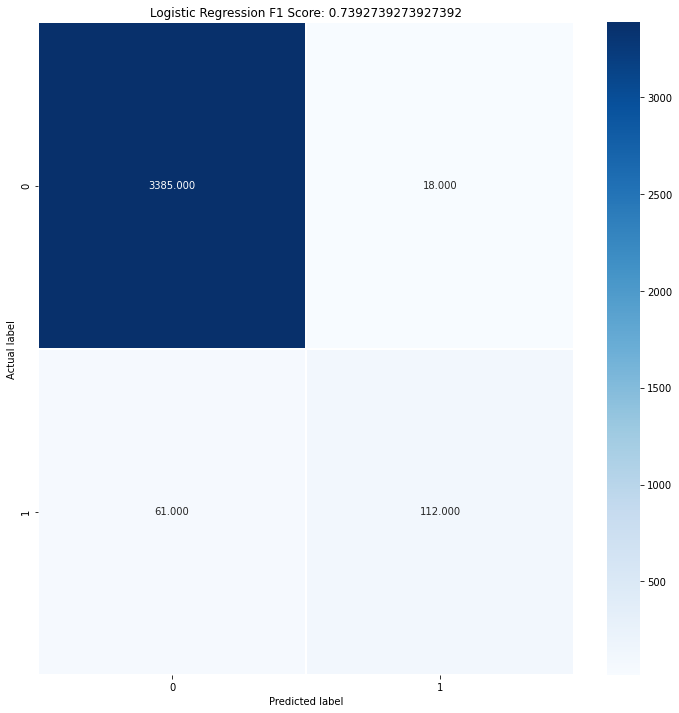

2 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 2:0:01:41.762570
Time predict of Fold 2:0:00:01.101870
F1_score of Fold 2: 0.7477744807121661


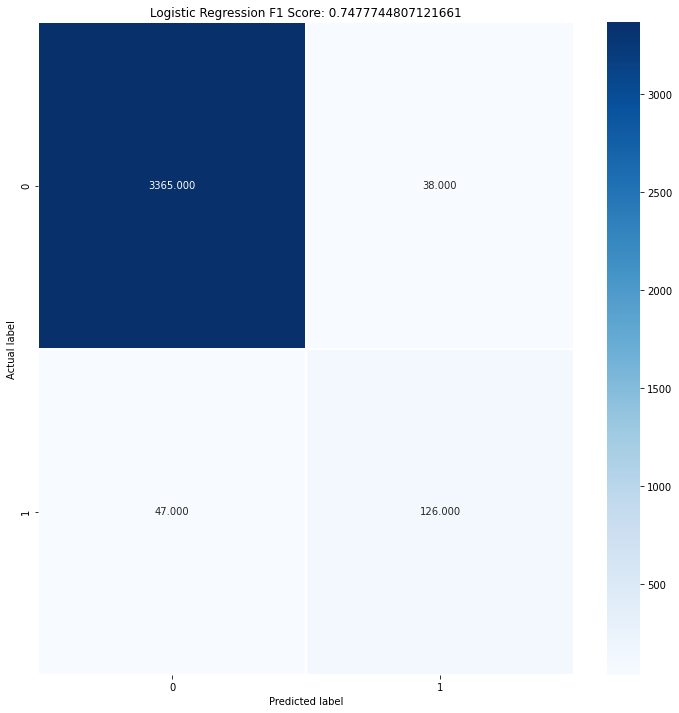

3 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 3:0:01:39.219270
Time predict of Fold 3:0:00:01.103090
F1_score of Fold 3: 0.6709265175718849


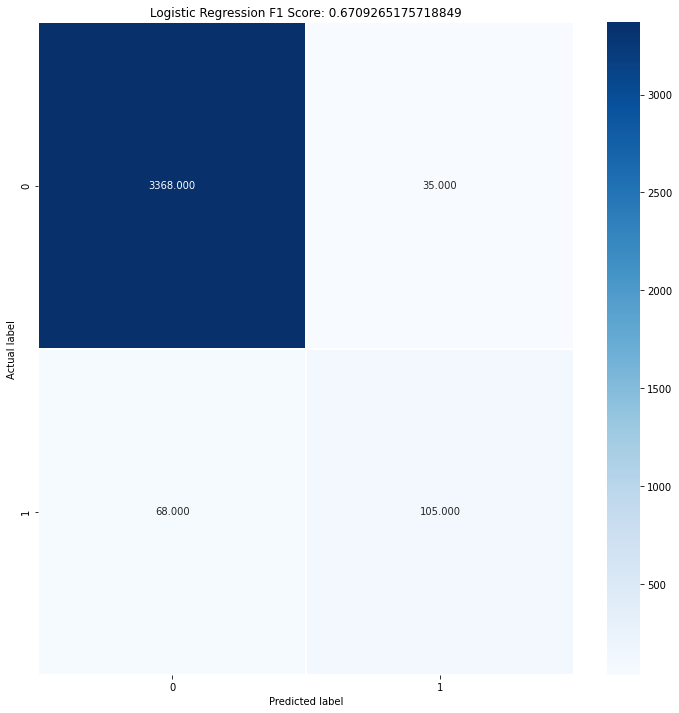

4 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 4:0:01:42.819090
Time predict of Fold 4:0:00:01.113810
F1_score of Fold 4: 0.7223880597014924


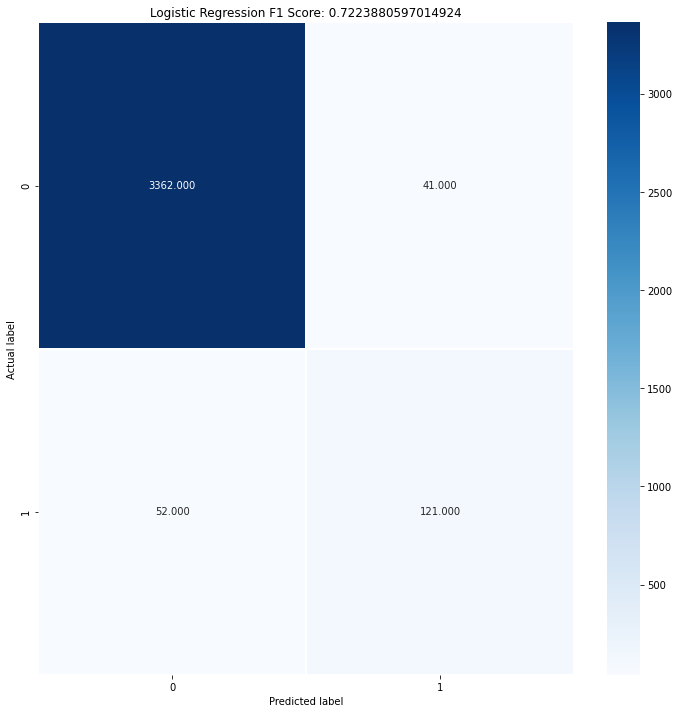

5 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 5:0:01:39.416200
Time predict of Fold 5:0:00:01.123020
F1_score of Fold 5: 0.752136752136752


Total time runing: 0:09:31.383100
Mean f1_score = 0.73


In [ ]:
#bow - Random Forest
start = time.time()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = []  
i = 1
predictions = 0

for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = bow_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = bow_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)
   
    rf_start = time.time()
    rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(Xtrain_bow, Ytrain_bow)
    rf_end = time.time()
    time_train = timedelta(seconds=round(rf_end - rf_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    rf_start = time.time()
    preds = rf.predict(test_X_vec)
    rf_end = time.time()
    time_pred = timedelta(seconds=round(rf_end - rf_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    rf_cm = metrics.confusion_matrix(yvalid_bow, preds)

    plt.figure(figsize=(12,12))
    sns.heatmap(rf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Logistic Regression F1 Score: {0}'.format(scores)
    plt.title(title)
    plt.show()

    cv_scores.append(scores)
    i += 1

end = time.time()
print('Total time runing:', timedelta(seconds=round(end - start,5)))
print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))

#Nhận xét:
- Tổng thời gian chạy là 9.44m.
- Mean của độ đo f1-score cho 5 fold là 73% cao hơn so với phương pháp Hold out 72%.
- Thời gian train nhanh hơn khoảng 2p so với Hold out
- Thời gian predict nhanh hơn khoảng 2s so với Hold out

1 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 1:0:01:36.423250
Time predict of Fold 1:0:00:01.126900
F1_score of Fold 1: 0.7482014388489209


2 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 2:0:01:39.211940
Time predict of Fold 2:0:00:01.121230
F1_score of Fold 2: 0.7553956834532374


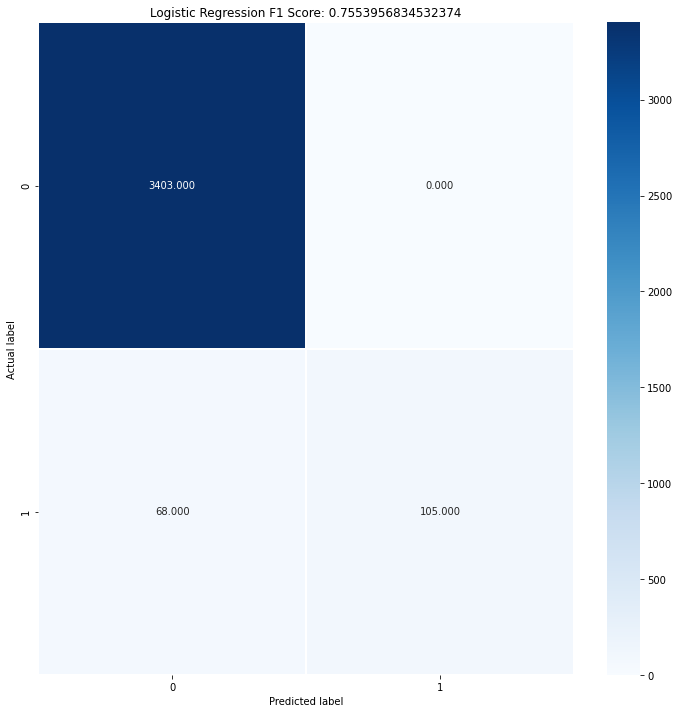

3 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 3:0:01:35.424830
Time predict of Fold 3:0:00:01.126210
F1_score of Fold 3: 0.7205882352941178


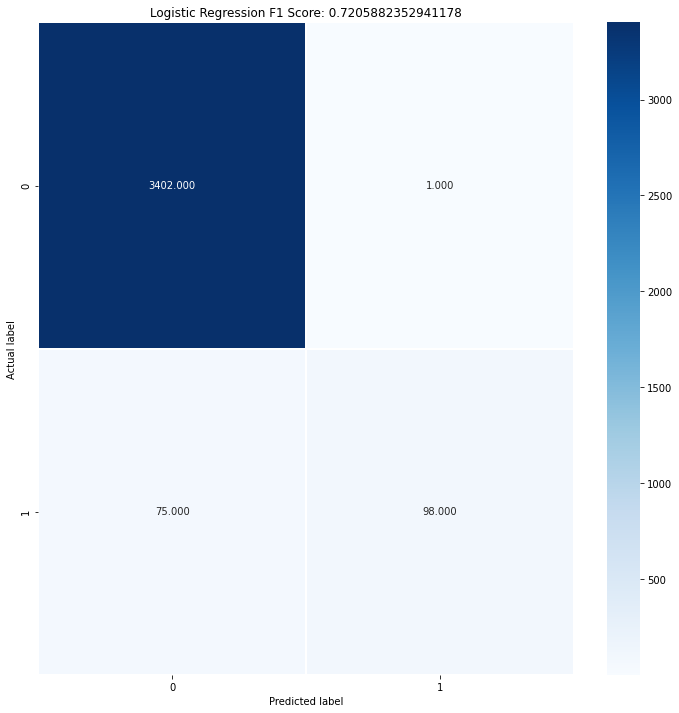

4 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 4:0:01:35.665060
Time predict of Fold 4:0:00:01.151960
F1_score of Fold 4: 0.8095238095238095


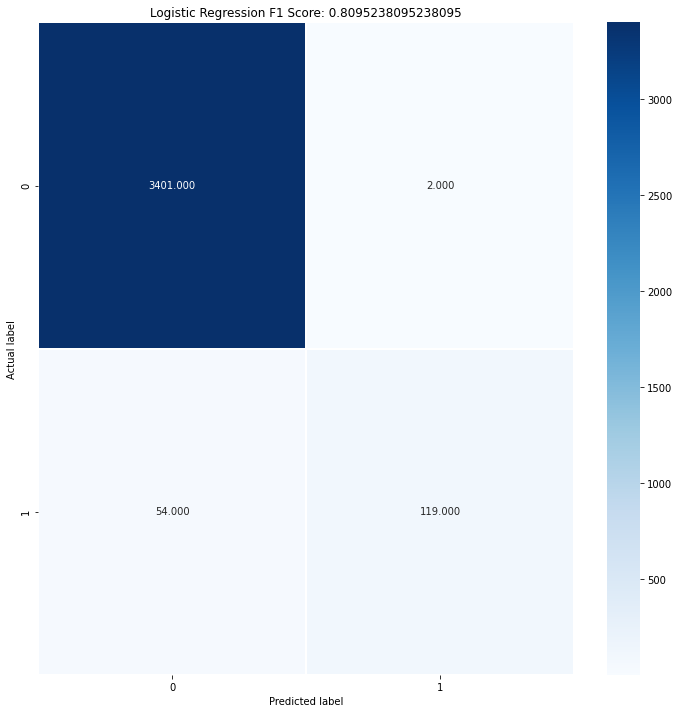

5 of KFold 5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Time training of Fold 5:0:01:37.418780
Time predict of Fold 5:0:00:01.136330
F1_score of Fold 5: 0.8054607508532422


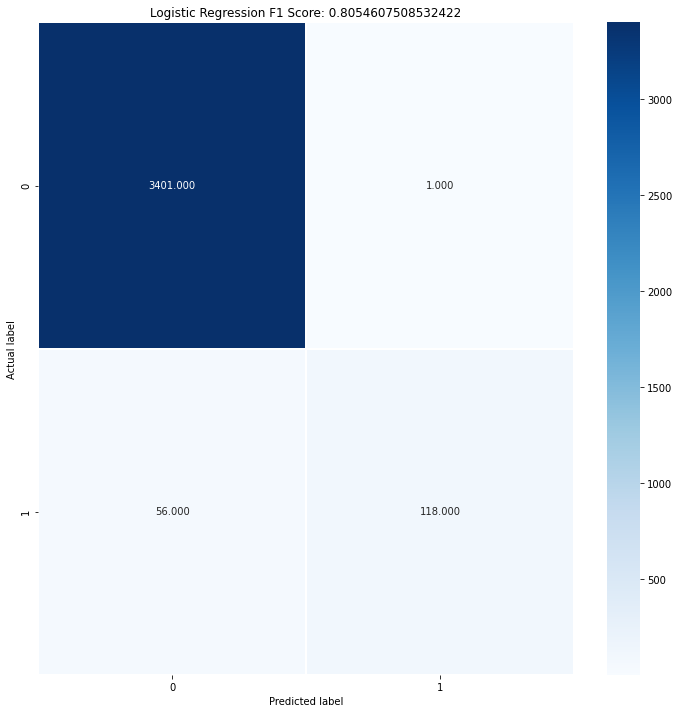

Total time runing: 0:09:27.182120
Mean f1_score = 0.77


In [ ]:
#tfidf - Random Forest
start = time.time()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = []  
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = tfidf_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = tfidf_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)

    rf_start = time.time()
    rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(Xtrain_bow, Ytrain_bow)
    rf_end = time.time()
    time_train = timedelta(seconds=round(rf_end - rf_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    rf_start = time.time()
    preds = rf.predict(test_X_vec)
    rf_end = time.time()
    time_pred = timedelta(seconds=round(rf_end - rf_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    rf_cm = metrics.confusion_matrix(yvalid_bow, preds)

    plt.figure(figsize=(12,12))
    sns.heatmap(rf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Logistic Regression F1 Score: {0}'.format(scores)
    plt.title(title)
    plt.show()

    cv_scores.append(scores)
    i += 1


end = time.time()
print('Total time runing:', timedelta(seconds=round(end - start,5)))
print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))

#Nhận xét:
- Tổng thời gian chạy là 1.19s.
- Mean của độ đo f1-score cho 5 fold là 77% thấp hơn so với phương pháp Hold out 78%.
- Thời gian train và predict cho từng Fold nhanh hơn phương pháp Hold out 1 ít nhưng không đáng kể. 

### Hyperparameter Tuning GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
xtrain_bow, xvalid_bow, ytrain_bow, yvalid_bow = train_test_split(bow,df.fraudulent, random_state= 42, test_size=0.3,\
                                                                  stratify=df.fraudulent)

In [ ]:
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(tfidf,df.fraudulent, random_state= 42, test_size=0.3,\
                                                                          stratify=df.fraudulent)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_it

Best: 0.984294 using {'C': 10}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 1.0, 'Logistic Regression F1 Score: 0.7395264116575592')

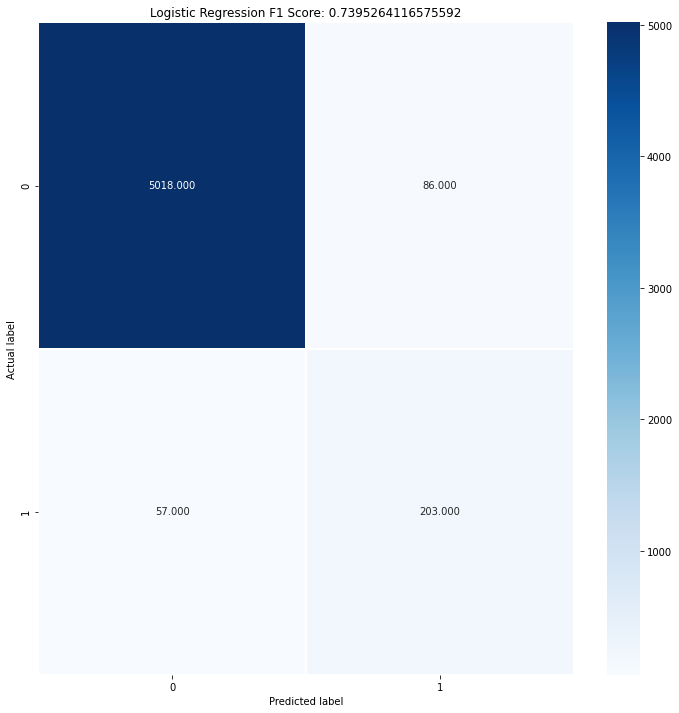

In [ ]:
#bow - Logisstic
# Sử dụng GridSearchCV để tuning hyper-parameter cho thuật toán Logistic Regression. Sử dụng param C để tunning và chọn C tốt nhất
# Trong Logistic Regression ta sử dụng tham số C để xác định vùng phân chia giữa các lớp (tương tự như C trong SVM)
# Giá trị C càng nhỏ, ta sẽ tăng trọng số của regularization, giúp mô hình đơn giản hơn và cũng dễ dẫn đến underfitting 
# Giá trị C càng nhỏ, ta sẽ giảm trọng số của regularization, giúp mô hình phức hơn và cũng dễ dẫn đến overfitting
parameter_candidates = [{'C':[0.001,0.01,0.1,1,10,100]}]
# Thực hiện Over Sampling
sm = SMOTE(random_state = 42)
Xtrain_bow, Ytrain_bow = sm.fit_sample(xtrain_bow, ytrain_bow)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác.
clf = GridSearchCV(estimator=LogisticRegression(), param_grid=parameter_candidates, scoring='f1_macro')

#train model
clf.fit(Xtrain_bow, Ytrain_bow)
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))

# dự đoán tập valid
y_pred = clf.best_estimator_.predict(xvalid_bow)
# Tính ma trận nhầm lẫn
lreg_cm = confusion_matrix(yvalid_bow, y_pred)
scores = metrics.f1_score(yvalid_bow, y_pred)

plt.figure(figsize=(12,12))
sns.heatmap(lreg_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression F1 Score: {0}'.format(scores)
plt.title(title)

- Sau khi tunning, ta thấy với C=10 là phù hợp với dữ liệu nhất so với những giá trị còn lại.
- Độ chính xác 74%.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_it

Best: 0.997061 using {'C': 100}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Text(0.5, 1.0, 'Logistic Regression F1 Score: 0.8884381338742394')

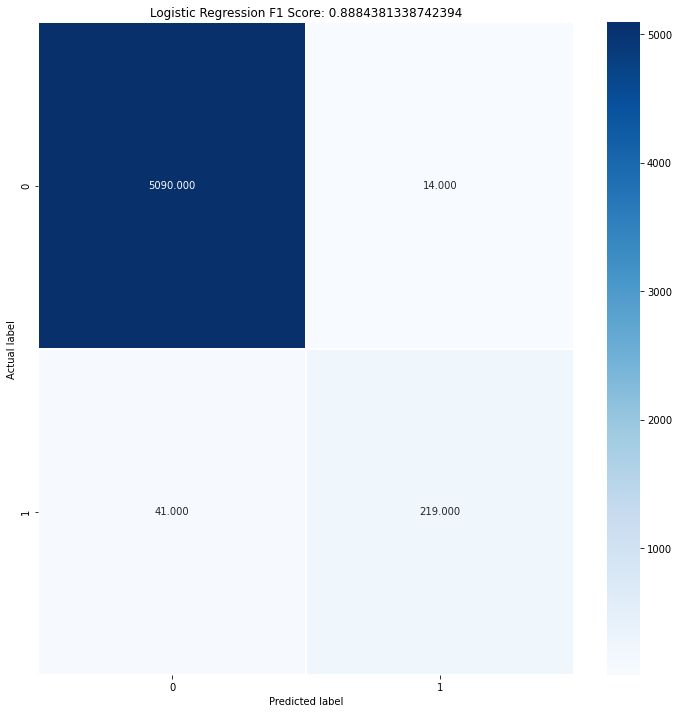

In [ ]:
#TFIDF - Logisstic
# Sử dụng GridSearchCV để tuning hyper-parameter cho thuật toán Logistic Regression. Sử dụng param C để tunning và chọn C tốt nhất
# Trong Logistic Regression ta sử dụng tham số C để xác định vùng phân chia giữa các lớp (tương tự như C trong SVM)
# Giá trị C càng nhỏ, ta sẽ tăng trọng số của regularization, giúp mô hình đơn giản hơn và cũng dễ dẫn đến underfitting 
# Giá trị C càng nhỏ, ta sẽ giảm trọng số của regularization, giúp mô hình phức hơn và cũng dễ dẫn đến overfitting
parameter_candidates = [{'C':[0.001,0.01,0.1,1,10,100]}]
# Thực hiện Over Sampling
sm = SMOTE(random_state = 42)
Xtrain_tfidf, Ytrain_tfidf = sm.fit_sample(xtrain_tfidf, ytrain_tfidf)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác.
clf = GridSearchCV(estimator=LogisticRegression(), param_grid=parameter_candidates, scoring='f1_macro')

#train model 
clf.fit(Xtrain_tfidf, Ytrain_tfidf)
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))

# dự đoán tập valid
y_pred = clf.best_estimator_.predict(xvalid_tfidf)

# Tính ma trận nhầm lẫn
lreg_cm = confusion_matrix(yvalid_tfidf, y_pred)
scores = metrics.f1_score(yvalid_tfidf, y_pred)

plt.figure(figsize=(12,12))
sns.heatmap(lreg_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression F1 Score: {0}'.format(scores)
plt.title(title)

- Sau khi tunning, ta thấy với C=100 là phù hợp với dữ liệu nhất so với những giá trị còn lại.
- Độ chính xác 89% cao hơn những dự đoán trước 5%.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.990678 using {'C': 10, 'kernel': 'rbf'}


Text(0.5, 1.0, 'SVM F1 Score: 0.7852760736196319')

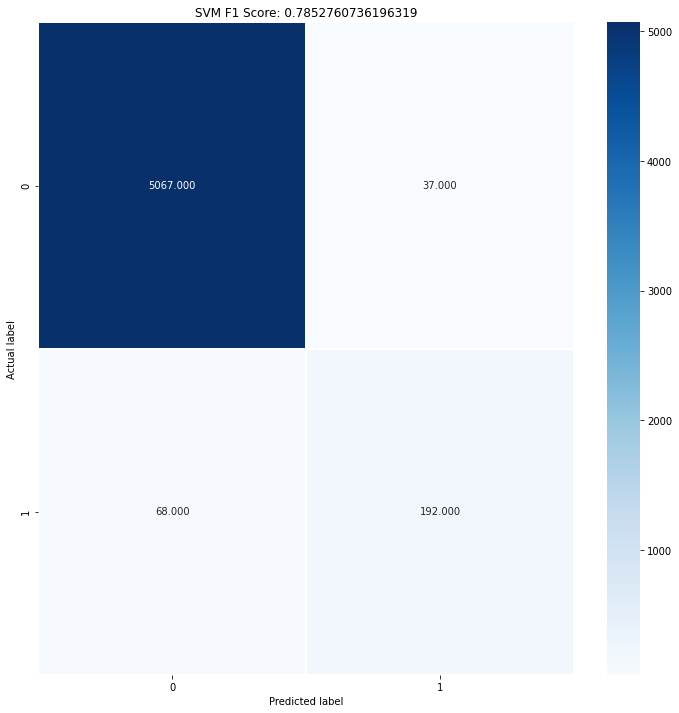

In [ ]:
#bow - SVM
# Sử dụng GridSearchCV để tuning hyper-parameter cho SVM
# Tunning tham số C và Kernel cho thuật toán SVM
# C để tìm margin nào trong 3 C bên dưới phù hợp với dữ liệu
# tìm Kerel nào phù hợp nhất với dữ liệu trong 3 bên dưới
parameter_candidates = [{'C':[1, 5, 10], 'kernel':['linear', 'rbf', 'poly']}]
# Thực hiện Over Sampling   
sm = SMOTE(random_state = 42)
Xtrain_bow, Ytrain_bow = sm.fit_sample(xtrain_bow, ytrain_bow)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác.
clf = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates, scoring='f1_macro')

#traini model 
clf.fit(Xtrain_bow, Ytrain_bow)
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))

# dự đoán tập valid
y_pred = clf.best_estimator_.predict(xvalid_bow)
# Tính ma trận nhầm lẫn
svm_cm = confusion_matrix(yvalid_bow, y_pred)
scores = metrics.f1_score(yvalid_bow, y_pred)

plt.figure(figsize=(12,12))
sns.heatmap(svm_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM F1 Score: {0}'.format(scores)
plt.title(title)

- Sau khi tunning, ta thấy với C=10 và kernel là rbf là phù hợp với dữ liệu nhất so với những giá trị còn lại.
- Độ chính xác 79% cao hơn những dự đoán trước 7%.

In [ ]:
#TFIDF - SVM
# Sử dụng GridSearchCV để tuning hyper-parameter cho SVM
parameter_candidates = [{'C':[1, 5, 10], 'kernel':['rbf', 'poly','linear']}]
# Thực hiện Over Sampling
sm = SMOTE(random_state = 42)
Xtrain_tfidf, Ytrain_tfidf = sm.fit_sample(xtrain_tfidf, ytrain_tfidf)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác. 
clf = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates, scoring='f1_macro')

#train model 
clf.fit(Xtrain_tfidf, Ytrain_tfidf)
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))

# dự đoán tập valid
y_pred = clf.best_estimator_.predict(xvalid_tfidf)
# Tính ma trận nhầm lẫn
svm_cm = confusion_matrix(yvalid_tfidf, y_pred)
scores = metrics.f1_score(yvalid_tfidf, y_pred)

plt.figure(figsize=(12,12))
sns.heatmap(svm_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM F1 Score: {0}'.format(scores)
plt.title(title)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


KeyboardInterrupt: ignored

In [ ]:
#bow - Random Forest
# Sử dụng GridSearchCV để tuning hyper-parameter cho thuật toán Random Forest
parameter_candidates = {'max_depth': [30, 50, 70, 90],
  'max_features': ['auto', 'sqrt'],
  'n_estimators': [400, 600, 800, 1000]}
# Thực hiện Over Sampling  
sm = SMOTE(random_state = 42)
Xtrain_bow, Ytrain_bow = sm.fit_sample(xtrain_bow, ytrain_bow)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác.
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates, scoring='f1_macro')

#train model
clf.fit(Xtrain_bow, Ytrain_bow)
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))

# dự đoán tập valid
y_pred = clf.best_estimator_.predict(xvalid_bow)

# Tính ma trận nhầm lẫn
rf_cm = confusion_matrix(yvalid_bow, y_pred)
scores = metrics.f1_score(yvalid_bow, y_pred)

plt.figure(figsize=(12,12))
sns.heatmap(svm_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest F1 Score: {0}'.format(scores)
plt.title(title)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#TFIDF - Random Forest
# Sử dụng GridSearchCV để tuning hyper-parameter cho thuật toán Random Forest
# bootstap: True là có sử dụng phương pháp bootstrap để phân chia dữ liệu. False là các cây sẽ sử dụng toàn bộ dữ liệu.
# max_dept: là độ sâu tối đa của từng cây trong Forest.
# max_feature: số feature tối đa để thực hiện phân chia. sqrt: max_feature = sqrt(n_feature)
# min_samples_leaf: số lượng mẫu tối đa tại mỗi nút lá.
# min_samples_split: số lượng mẫu tối thiểu tại mỗi nút.
# n_estimators: số lượng cây trong Forest
parameter_candidates = {'max_depth': [30, 50, 70, 90],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [400, 600, 800, 1000]}
# Thực hiện Over Sampling  
sm = SMOTE(random_state = 42)
Xtrain_tfidf, Ytrain_tfidf = sm.fit_sample(xtrain_tfidf, ytrain_tfidf)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác. 
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates, scoring='f1_macro')

#train model
clf.fit(Xtrain_tfidf, Ytrain_tfidf)
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))

# dự đoán tập valid
y_pred = clf.best_estimator_.predict(xvalid_tfidf)

# Tính ma trận nhầm lẫn
rf_cm = confusion_matrix(yvalid_tfidf, y_pred)
scores = metrics.f1_score(yvalid_tfidf, y_pred)

plt.figure(figsize=(12,12))
sns.heatmap(svm_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest F1 Score: {0}'.format(scores)
plt.title(title)